## Import libraries

In [12]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import PA_Utils as pa_ut
warnings.simplefilter(action='ignore', category=FutureWarning)
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from scipy.stats import ttest_1samp
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch 

## Functions

In [13]:
def plot_within_session_perf(df, Participant_ID, save_path, show_plot=False, jitter=0.05, background_shading=True):
    with PdfPages(save_path) as pdf:
        participant_df = df[df['Participant_ID'] == Participant_ID]
        participant_df = participant_df[participant_df['No_response'] == False]

        for block in participant_df.block.unique():
            block_df = participant_df[participant_df['block'] == block].reset_index(drop=True)
            # fig, ax = plt.subplots(figsize=(18, 6))
            fig, axs = plt.subplots(2, 1, figsize=(18, 12)) # Create 2 subplots
            ax = axs[0]
            y_labels = ['Pro Go L', 'Go L', 'Anti Go L', 'Pro Go R', 'Go R', 'Anti Go R']
            ax.set_yticks([0, 0.5, 1, 2, 2.5, 3])
            ax.set_yticklabels(y_labels)
            ax.set_xlabel('(Valid) Trial')
            ax.set_ylabel('Condition')

            # Background shading along x-axis
            if background_shading:
                start_index = 0
                current_type = block_df['Air_Puff_Contingency'].iloc[0]
                for i, row in block_df.iterrows():
                    if row['Air_Puff_Contingency'] != current_type:
                        color = 'lightgreen' if current_type == 'Pro' else 'lightcoral'
                        ax.axvspan(start_index - 0.5, i - 0.5, facecolor=color, alpha=0.2)
                        start_index = i
                        current_type = row['Air_Puff_Contingency']
                # Shade the final block
                color = 'lightgreen' if current_type == 'Pro' else 'lightcoral'
                ax.axvspan(start_index - 0.5, i + 0.5, facecolor=color, alpha=0.2)


            # Mapping conditions to y-values using a dictionary
            y_map = {
                ('Pro', 0): 0,
                ('Anti', 0): 1,
                ('Pro', 1): 2,
                ('Anti', 1): 3
            }

            colors = ['green' if correct else 'red' for correct in block_df['correct']]
            y_values = block_df.apply(lambda row: y_map.get((row['Air_Puff_Contingency'], row['choice'])), axis=1)

            # Add jitter to y-values
            y_values += np.random.uniform(-jitter, jitter, len(y_values))

            # Plotting the points
            ax.scatter(block_df.index, y_values, color=colors, s=50, alpha=0.5)

            # Plotting black dots based on choice
            for index, choice in block_df['choice'].items():
                y = 0.5 if choice == 0 else 2.5
                y += np.random.uniform(-jitter, jitter)
                ax.plot(index, y, 'o', color='saddlebrown', markersize=7, alpha=0.5)

            ax.set_xlim(-3, block_df.index[-1] + 3)
            ax.set_title(f'Participant {Participant_ID} on {block_df.Date[0]} (Block {block})', y = 1.05, fontdict={'fontsize': 18})

            ax2 = axs[1]

            ax2.plot(block_df.index, block_df['correct'].rolling(30, center=True).mean(), color='green', label='Performance', linewidth=3)
            ax2.plot(block_df.index, block_df['choice'].rolling(30, center=True).mean(), color='saddlebrown', label='Choice', linewidth=3)

            ax2.set_xlabel('(Valid) Trial')
            ax2.set_ylabel('Proportion')
            ax2.axhline(0.5, color='k', linestyle='--')
            ax2.set_ylim([0, 1])
            ax2.set_xlim(-3, block_df.index[-1] + 3)
            ax2.legend()

            plt.tight_layout()
            # Save figure to pdf
            pdf.savefig(fig)

            # Show figure
            if show_plot:
                plt.show()
            else:
                plt.close()

def add_previous_n_trials_data(group, n=7):
    """
    Add previous n trial data (stim_relative_binned, choice, and correct) to the DataFrame for each participant.
    
    Parameters
    ----------
    group : pd.DataFrame
        The data for a single participant, assumed to have the columns 'Trial', 'No_response',
        'stim_relative_binned', 'choice', and 'correct'.
    n : int
        Number of previous trials to include.
        
    Returns
    -------
    group : pd.DataFrame
        The modified input DataFrame with additional columns for previous trial data
        ('stim_relative_1', 'choice_1', 'correct_1', ... up to n).
    """
    for i in range(1, n+1):
        # Shift the stim_relative_binned, choice, and correct columns by i rows to get previous trial data
        group[f'stim_relative_binned_{i}'] = group['stim_relative_binned'].shift(i)
        group[f'stim_relative_{i}'] = group['Stim_Relative'].shift(i)
        group[f'choice_{i}'] = group['choice'].shift(i)
        group[f'correct_{i}'] = group['correct'].shift(i)
        
        # Set the new columns to NaN for the first i trials of each participant
        group.loc[group['Trial'] < i, [f'stim_relative_{i}', f'choice_{i}', f'correct_{i}']] = np.nan
        
        # Set choice_i and correct_i to NaN for trials where the previous trial had no response
        group.loc[group['No_response'].shift(i) == True, [f'choice_{i}', f'correct_{i}']] = np.nan

    return group

# Function to identify blocks and their sizes
def get_block_sizes(df, column_name):
    # Find where the choice changes
    change_points = df[column_name].diff().ne(0)
    # Identify block start points
    block_starts = df.index[change_points].tolist()
    # Include the start of the first block and the end of the last block
    block_starts.insert(0, df.index[0])
    block_starts.append(df.index[-1] + 1)  # Add 1 because it is the end point, non-inclusive
    # Calculate block sizes
    block_sizes = [block_starts[i+1] - block_starts[i] for i in range(len(block_starts)-1)]
    return block_sizes

def compute_p_stay(sub_df):
    # calculate p_stay independent of reward
    p_stay = (sub_df['choice'] == sub_df['choice_1']).mean()
    
    # Given reward
    reward_df = sub_df[sub_df['correct_1'] == 1]
    p_stay_given_reward = (reward_df['choice'] == reward_df['choice_1']).mean()

    # No reward
    no_reward_df = sub_df[sub_df['correct_1'] == 0]
    p_stay_given_no_reward = (no_reward_df['choice'] == no_reward_df['choice_1']).mean()

    return p_stay, p_stay_given_reward, p_stay_given_no_reward

def plot_run_lengths(df):
    unique_pids = df['Participant_ID'].unique()
    num_rows = len(unique_pids) // 3 + (len(unique_pids) % 3 > 0)
    num_cols = min(3, len(unique_pids))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 18))
    axes = axes.ravel()

    for i, p_id in enumerate(unique_pids):
        subj_df = df[df['Participant_ID'] == p_id]
        valid_df = subj_df[subj_df['No_response'] == False]
        
        blockiness = []
        sem_values = []
        for date in valid_df['Date'].unique():
            date_df = valid_df[valid_df['Date'] == date]
            block_sizes = get_block_sizes(date_df, 'choice')
            blockiness_mean = np.mean(block_sizes)
            blockiness.append(blockiness_mean)
            
            # Calculate SEM
            sem = np.std(block_sizes) / np.sqrt(len(block_sizes))
            sem_values.append(sem)

        # Plot with error bars
        axes[i].errorbar(range(len(blockiness)), blockiness, yerr=sem_values, label=p_id, fmt='-o', color = 'k')
        axes[i].set_title(p_id)
        axes[i].set_ylim(0, 20)
        # set y ticks
        axes[i].set_yticks(np.arange(0, 26, 5))
        # set x label
        axes[i].set_xlabel('Session')
        # set y label
        axes[i].set_ylabel('Avg. Run Length')

    for j in range(len(unique_pids), num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_p_stay(df, Animal_List, save_path = None):
    """
    Creates and displays a plot showing P(Stay), P(Stay/R), and P(Stay/¬R) for each participant.
    
    :param df: The input dataframe
    :param Animal_List: The list of participant IDs to plot
    :param compute_p_stay: The function to compute P(Stay), P(Stay/R), and P(Stay/¬R)
    :param title: The title of the plot, which will be used in the saved filename if save_path is provided
    :param save_dir: The directory to save the resulting plot, if None, plot is not saved
    """
    # Define the number of rows and columns for subplots
    unique_pids = df['Participant_ID'].unique()
    n_rows = len(unique_pids) // 3 + (len(unique_pids) % 3 > 0)
    n_cols = min(3, len(unique_pids))

    # Create subplots with specified number of rows and columns
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 8 * n_rows))

    # Flatten the axs array for easy iteration
    axs = axs.ravel()
    line_colors = {'P(Stay)': 'blue', 'P(Stay/R)': 'magenta', 'P(Stay/¬R)': 'green'}

    for idx, participant in enumerate(Animal_List):
        participant_df = df[df['Participant_ID'] == participant]
        dates = participant_df['Date'].unique()

        # p_stay = []
        p_reward = []
        p_no_reward = []

        for date in dates:
            date_df = participant_df[participant_df['Date'] == date]
            p, p_r, p_nr = compute_p_stay(date_df)
            # p_stay.append(p)
            p_reward.append(p_r)
            p_no_reward.append(p_nr)

        # Plot lines with specified colors from the dictionary
        # axs[idx].plot(dates, p_stay, '-o', label='P(Stay)', color=line_colors['P(Stay)'])
        axs[idx].plot(dates, p_reward, '-o', label='P(Stay/R)', color=line_colors['P(Stay/R)'])
        axs[idx].plot(dates, p_no_reward, '-x', label='P(Stay/¬R)', color=line_colors['P(Stay/¬R)'])
        axs[idx].set_ylim(0, 1)
        axs[idx].axhline(y=0.5, color='k', linestyle='--', label='Chance')
        axs[idx].set_xlabel('Date')
        axs[idx].set_ylabel('Probability')
        axs[idx].set_title(f'Participant {participant}', fontdict={'fontsize': 12})
        axs[idx].legend()
        # rotate the xticks
        axs[idx].tick_params(axis='x', rotation=45)
        # only show every 5th xtick
        for i, label in enumerate(axs[idx].get_xticklabels()):
            if i % 5 != 0:
                label.set_visible(False)

    # Hide any remaining unused subplots
    for j in range(idx + 1, n_rows * n_cols):
        axs[j].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    plt.show()

def get_perf_around_switch(df, from_state, to_state, window = 10):
    '''
    Calculate the performance around a switch from one state to another.
    Args:
        df (DataFrame): The DataFrame to use.
        from_state (str): The state to switch from.
        to_state (str): The state to switch to.
        window (int): The number of trials to include before and after the switch.
    Returns:
        perf_means (array): The mean performance for each trial around the switch.
        perf_sems (array): The standard error of the mean for each trial around the switch.
    '''
    # Find the indices of the switches
    transition_indices = df.index[(df['Air_Puff_Contingency'].shift(1) == from_state) &
                            (df['Air_Puff_Contingency'] == to_state)]
    # Create a matrix to store the performance around each switch
    switch_matrix = np.zeros((len(transition_indices), window*2+1))
    # Loop through each switch
    for i, transition in enumerate(transition_indices):
        # Find the start and end indices for the window
        start_index = max(transition-window, 0)
        end_index = min(transition+window+1, len(df)+1)
        # Get the windowed DataFrame
        window_df = df.iloc[start_index:end_index].reset_index(drop=True)
        # Add the performance to the matrix
        switch_matrix[i][:window] = window_df['correct'][:window]
        switch_matrix[i][-(window+1):] = window_df['correct'][-(window+1):]
    # Calculate the mean and standard error of the mean for each trial
    perf_means = np.mean(switch_matrix, axis=0)
    perf_sems = np.std(switch_matrix, axis=0) / np.sqrt(len(transition_indices))

    return perf_means, perf_sems

def plot_psych_quadrant(df, save_path = None):
    '''
    Plot psychometric curve for each quadrant for pro and anti, air puff left and right,
    all in the same quadrant
    Args:
        df (DataFrame): The DataFrame to use.
    Returns:
        None
    '''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))    

    # Expanded color dictionary with unique colors for each condition
    color_dict = {
        'Air Puff Right, Stim < 0': '#1f77b4',  # example color
        'Air Puff Right, Stim > 0': '#ff7f0e',  # example color
        'Air Puff Left, Stim < 0': '#2ca02c',   # example color
        'Air Puff Left, Stim > 0': '#d62728'    # example color
    }

    air_puff_R_below_0 = df[(df['Air_Puff_Side'] == 'Right') & (df['Stim_Relative'] < 0)]
    air_puff_R_above_0 = df[(df['Air_Puff_Side'] == 'Right') & (df['Stim_Relative'] > 0)]
    air_puff_L_below_0 = df[(df['Air_Puff_Side'] == 'Left') & (df['Stim_Relative'] < 0)]
    air_puff_L_above_0 = df[(df['Air_Puff_Side'] == 'Left') & (df['Stim_Relative'] > 0)]
    sns.pointplot(x=(air_puff_R_below_0.stim_relative_binned * (-1)), y='choice', 
                data=air_puff_R_below_0, capsize=0.1, ax=ax, ci=95, 
                label='Puff Right, Pro', color=color_dict['Air Puff Right, Stim < 0'])
    sns.pointplot(x=air_puff_R_above_0.stim_relative_binned, y= (1 - air_puff_R_above_0.choice),
                data=air_puff_R_above_0, capsize=0.1, ax=ax, ci=95, 
                label='Puff Right, Anti', color=color_dict['Air Puff Right, Stim > 0'])
    sns.pointplot(x=(air_puff_L_below_0.stim_relative_binned * (-1)), y=(1 - air_puff_L_below_0.choice),
                data=air_puff_L_below_0, capsize=0.1, ax=ax, ci=95, 
                label='Puff Left, Pro', color=color_dict['Air Puff Left, Stim < 0'])
    sns.pointplot(x=air_puff_L_above_0.stim_relative_binned, y=air_puff_L_above_0.choice,
                data=air_puff_L_above_0, capsize=0.1, ax=ax, ci=95, 
                label='Puff Left, Anti', color=color_dict['Air Puff Left, Stim > 0'])


    ax.legend(loc = 'lower right')

    ax.set_ylim(0.5, 0.9)
    ax.axhline(y=0.5, color='black', linestyle='--')
    ax.set_title('Absolute Psychometric Curves')
    ax.set_xlabel('Stimulus Intensity')
    ax.set_ylabel('Proportion Correct Choice')
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def calculate_average_run_length(df, participant_col, block_col, contingency_col):
    # Convert the contingency column to a categorical type
    df[contingency_col] = df[contingency_col].astype('category')

    # Function to calculate the average run length for each group
    def average_run_length(group):
        cat_codes = group[contingency_col].cat.codes
        diffs = cat_codes.diff().ne(0)
        runs = diffs.cumsum()
        run_counts = runs.value_counts()
        # Calculate the average run length
        avg_run_length = run_counts.mean()
        return avg_run_length

    # Group by participant and block columns, then apply the average_run_length function
    avg_run_length_df = df.groupby([participant_col, block_col]).apply(average_run_length).reset_index()

    # Rename columns for clarity
    avg_run_length_df.columns = [participant_col, block_col, 'Average_Contingency_Run_Length']
    
    return avg_run_length_df

## Fetch Data

In [14]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'PRO_ANTI'
data_type = 'Trial_Summary'

Animal_List = [
              # 'QP069', 
              # 'QP070', 
              # 'QP077', 
              'QP083', 'QP084', 'QP085', 
              # 'QP090', 
              # 'QP091', 
              # 'QP092',  
              # 'QP0104',  
              # 'QP0105', 
              # 'QP0106', 
              # 'QP0107', 
              'QP0108',
              # 'QP0113',
            #   'QP0114',
              # 'QP0115',
              # 'QP0116',
              # 'QP0117',
            #   'QP0118',
              ]

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_PA_V2.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = pa_ut.get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data = pd.concat([all_data, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data, f)

Processing QP0108: 100%|██████████| 107/107 [00:58<00:00,  1.84it/s]


## Process Data

In [15]:
df = all_data

df['Datetime'] = pd.to_datetime(df['Date'])
date_limit = '2023/09/26'  
df = df[df['Datetime'] >= date_limit]
# reference df for the first session with new protocol
# ref_df = pd.read_csv('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP077/PRO_ANTI_QP077_2023_9_25/Trial_Summary2023-09-25T10_02_59.csv')
# columns_list = ref_df.columns.tolist()
columns_list = ['Animal_ID', 'Protocol', 'Stage', 'Trial_Number', 'Correct_Count', 'Sound_Contingency', 'Stim_Relative', 'Correct', 'Abort_Trial', 'Rule',
                'Reward_Side', 'First_Lick', 'Correct_Side', 'P_Right', 'Response_Latency', 'Trial_Outcome', 'Inter_Trial_Interval', 'Sound_Duration', 
                'Go_Cue_Duration', 'Stim_Type', 'Stim_Range_Min', 'Stim_Range_Max', 'Anti_Bias', 'Nb_Of_Stim', 'Response_Window', 'Timeout_Duration', 
                'Emulator', 'Distribution', 'Distribution_Exp_Rate', 'Left_Valve_Time', 'Right_Valve_Time', 'Air_Puff_Contingency', 'Window_Perf_Size', 
                'Min_Block_Length', 'Block_Performance_Threshold', 'Opto_On', 'Mask', 'Fiber', 'Perc_Opto_Trials', 'Opto_Onset_1', 'Opto_Offset_1', 
                'Air_Puff_Side', 'Opto_Onset_2', 'Opto_Offset_2', 'Trial_End_Time', 'Delay_Period',  'Working_Memory_Delay']

# Add multiple columns
columns_list.extend(['Date', 'Datetime'])
df = pa_ut.grab_columns(df, columns_list)

# combine the Delay_Period and Working_Memory_Delay columns into a single column called Working_Memory_Delay
df['Working_Memory_Delay'] = df['Working_Memory_Delay'].fillna(df['Delay_Period'])

df['Air_Puff_Side'] = df.apply(pa_ut.compute_air_puff_side, axis=1)
# df = pa_ut.add_block_column(df, participant_col = 'Animal_ID', time_col = 'Trial_End_Time', trial_col =  'Trial_Number')
df['Animal_ID'] = pd.Categorical(df['Animal_ID'], categories=Animal_List, ordered=True)
df = pa_ut.add_block_column(df, participant_col = 'Animal_ID', datetime_col = 'Datetime', trial_end_time =  'Trial_End_Time', trial_col =  'Trial_Number')
df = pa_ut.process_raw_data(df)
df = df.reset_index(drop=True)
processed_df = df.copy()

In [16]:
# add the 'Air_Puff_Contingerncy_Rule' column
avg_run_length_df = calculate_average_run_length(df, 'Participant_ID', 'block', 'Air_Puff_Contingency')
df = df.merge(avg_run_length_df, on=['Participant_ID', 'block'])
# add a new column called Air_Puff_Contingency_Rule that is 'Random_Alternation' if the average run length is less 5, and 'Block' if the average run length is greater than 5
df['Air_Puff_Contingency_Rule'] = np.where(df['Average_Contingency_Run_Length'] <= 5, 'Random_Alternation', 'Block')

In [17]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

In [18]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Plot Data

In [ ]:
pa_ut.plot_performance_and_bias_all(df = df,
                                participant_ids = Animal_List,
                                color_dict = {'Pro': '#2F9A76', 'Anti': '#c23f63', 'Left': '#FFA500', 'Right': '#0000FF'},
                                save_path = figs_path + 'PA_Perf_And_Bias_All.pdf',
                                show_plot = False)

In [ ]:
# for every p_id, have as associated boolean wether to apply background shading or not
shading_dict = {
                'QP070': True, 
                'QP077': True,
                'QP083': False, 
                'QP084': False, 
                'QP085': False, 
                'QP090': True, 
                'QP091': True, 
                'QP092': False, 
                'QP0104': False, 
                'QP0105': False, 
                'QP0106': True, 
                'QP0107': True, 
                'QP0108': False,
                'QP0113': True,
                # 'QP0114': True,
                'QP0115': True,
                'QP0116': True,
                'QP0117': True,
                # 'QP0118': True,
                }

for p_id, shading in shading_dict.items():
    # pa_ut.
    plot_within_session_perf(df = df, Participant_ID =  p_id, save_path = figs_path +  p_id + '_Within_Session_Perf.pdf', 
                             show_plot = False, jitter = 0.05, background_shading = shading)

In [ ]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

In [ ]:
# I am looking at choice data (binary, 0 or 1) and I want to analyse to what extent the choice occur in 'blocks' of trials
# to do this, I want to take all the choice over time and collapse the x-axis to produce a histogram, does this make sense?

In [ ]:
# apply the add_previous_trial_data to each group
# df = df.groupby('Participant_ID', group_keys=False).apply(ut.add_previous_trial_data)
df = df.groupby('Participant_ID').apply(add_previous_n_trials_data)
df = df.groupby('Participant_ID', group_keys= False).apply(add_previous_n_trials_data)

In [ ]:
# plot_p_stay(df, Animal_List, save_path= figs_path + 'PA_P_Stay.pdf')

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## KDEs


In [30]:
def compute_kde(x_range, stimuli, choices, sigma = 0.1):
    """
    Computes the KDE for a given range of x values.
    Args:
        x_range (np.array): The range of x values to compute the KDE for
        stimuli (np.array): The array of stimuli
        choices (np.array): The array of choices
        sigma (float): The kernel width
    Returns:
        p (np.array): The KDE values for each x value    
    """
    # Calculate the distances between each x value and each stimulus
    d = np.abs(x_range[:, np.newaxis] - stimuli[np.newaxis, :])
    
    # Convert 'd' to a numeric type (e.g., float64)
    d = d.astype(np.float64)

    # Calculate the weights using the Gaussian kernel
    w = np.exp(-(1/2)*(d/sigma)**2)
    
    # Normalize the weights
    w = w / np.sum(w, axis=1)[:, np.newaxis]
    
    # Calculate the KDE values
    p = np.dot(w, choices)
    
    return p

def compute_bootstrap_kdes(x_range, s, c, sigma=0.1, n_bootstraps=100):
    """
    Computes the KDE for a given range of x values using bootstrapping.
    Args:
        x_range (np.array): The range of x values to compute the KDE for
        s (np.array): The array of stimuli
        c (np.array): The array of choices
        sigma (float): The kernel width
        n_bootstraps (int): The number of bootstraps to perform
    Returns:
        bootstrap_kdes (np.array): The KDE values for each x value for each bootstrap
    """
    indices = np.random.choice(len(s), size=(n_bootstraps, len(s)), replace=True)
    stimuli_resampled = s[indices]
    choices_resampled = c[indices]
    x_range_reshaped = x_range.reshape(len(x_range), 1, 1)

    # Using broadcasting for efficient computation
    d = x_range_reshaped - stimuli_resampled

    # convert 'd' to a numeric type (e.g., float64)
    d = d.astype(np.float64)

    w_new = np.exp(-(1 / 2) * (d / sigma) ** 2)

    # Combining sum and division in a single step
    w_new /= np.sum(w_new, axis=2, keepdims=True)

    bootstrap_kdes = np.zeros((n_bootstraps, len(x_range)))  # Pre-allocate array for performance
    for boot in range(n_bootstraps):
        kde = np.dot(w_new[:, boot, :], choices_resampled[boot])
        bootstrap_kdes[boot] = kde  # Store the result in pre-allocated array

    return bootstrap_kdes

In [ ]:
# remove no response trials
sub_df = df[df.No_response == False].reset_index(drop=True)
# remove all dara where air-puff-side or stim_relative is NaN
sub_df = sub_df.dropna(subset=['Air_Puff_Side', 'Stim_Relative']).reset_index(drop=True)
# remove all trials where Air_Puff_Contingency is Pro and Stim_Relative is positive
sub_df = sub_df[~((sub_df.Air_Puff_Contingency == 'Pro') & (sub_df.Stim_Relative > 0))].reset_index(drop=True)
# remove all trials where Air_Puff_Contingency is Anti and Stim_Relative is negative
sub_df = sub_df[~((sub_df.Air_Puff_Contingency == 'Anti') & (sub_df.Stim_Relative < 0))].reset_index(drop=True)

In [ ]:
# keep continuous data
sub_df = sub_df[sub_df['Stage'] == 'Full_Task_Cont'].reset_index(drop=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


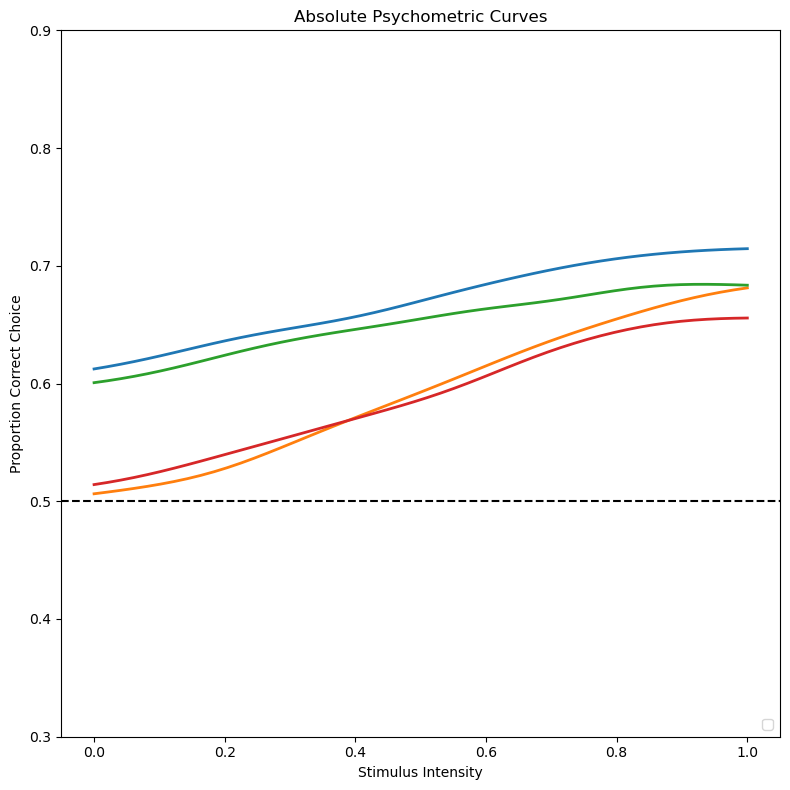

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))    

# Expanded color dictionary with unique colors for each condition
color_dict = {
    'Air Puff Right, Stim < 0': '#1f77b4',  # example color
    'Air Puff Right, Stim > 0': '#ff7f0e',  # example color
    'Air Puff Left, Stim < 0': '#2ca02c',   # example color
    'Air Puff Left, Stim > 0': '#d62728'    # example color
}

air_puff_R_below_0 = sub_df[(sub_df['Air_Puff_Side'] == 'Right') & (sub_df['Stim_Relative'] < 0)]
air_puff_R_above_0 = sub_df[(sub_df['Air_Puff_Side'] == 'Right') & (sub_df['Stim_Relative'] > 0)]
air_puff_L_below_0 = sub_df[(sub_df['Air_Puff_Side'] == 'Left') & (sub_df['Stim_Relative'] < 0)]
air_puff_L_above_0 = sub_df[(sub_df['Air_Puff_Side'] == 'Left') & (sub_df['Stim_Relative'] > 0)]

x_range = np.linspace(0, 1, 50)

kde_R_below_0 = compute_kde(x_range*(-1), air_puff_R_below_0.Stim_Relative.values, air_puff_R_below_0.choice.values)
kde_R_above_0 = compute_kde(x_range, air_puff_R_above_0.Stim_Relative.values, (1-air_puff_R_above_0.choice.values))
kde_L_below_0 = compute_kde(x_range*(-1), air_puff_L_below_0.Stim_Relative.values, (1-air_puff_L_below_0.choice.values))
kde_L_above_0 = compute_kde(x_range, air_puff_L_above_0.Stim_Relative.values, air_puff_L_above_0.choice.values)

ax.plot(x_range, kde_R_below_0, color=color_dict['Air Puff Right, Stim < 0'], linestyle='-', linewidth=2)
ax.plot(x_range, kde_R_above_0, color=color_dict['Air Puff Right, Stim > 0'], linestyle='-', linewidth=2)
ax.plot(x_range, kde_L_below_0, color=color_dict['Air Puff Left, Stim < 0'], linestyle='-', linewidth=2)
ax.plot(x_range, kde_L_above_0, color=color_dict['Air Puff Left, Stim > 0'], linestyle='-', linewidth=2)


# remove legend
ax.legend(loc = 'lower right')

ax.set_ylim(0.3, 0.9)
ax.axhline(y=0.5, color='black', linestyle='--')
ax.set_title('Absolute Psychometric Curves')
ax.set_xlabel('Stimulus Intensity')
ax.set_ylabel('Proportion Correct Choice')
plt.tight_layout()
plt.show()

In [ ]:
num_iterations = 10
boots_per_iter = 10
n = len(x_range)
kde_L_above_0_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))
kde_R_above_0_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))
kde_L_below_0_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))
kde_R_below_0_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))

for i in range(num_iterations):
    # print every 10th iteration
    if i % 10 == 0:
        print('Iteration: ', i)
    kde_R_below_0_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range*(-1),
            s = air_puff_R_below_0.Stim_Relative.values,
            c = air_puff_R_below_0.choice.values,
            sigma = 0.1,
            n_bootstraps = boots_per_iter)
    kde_R_above_0_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range,
            s = air_puff_R_above_0.Stim_Relative.values,
            c = (1-air_puff_R_above_0.choice.values),
            sigma = 0.1,
            n_bootstraps = boots_per_iter)
    kde_L_below_0_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range*(-1),
            s = air_puff_L_below_0.Stim_Relative.values,
            c = (1-air_puff_L_below_0.choice.values),
            sigma = 0.1,
            n_bootstraps = boots_per_iter)
    kde_L_above_0_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range,
            s = air_puff_L_above_0.Stim_Relative.values,
            c = air_puff_L_above_0.choice.values,
            sigma = 0.1,
            n_bootstraps = boots_per_iter)

Iteration:  0


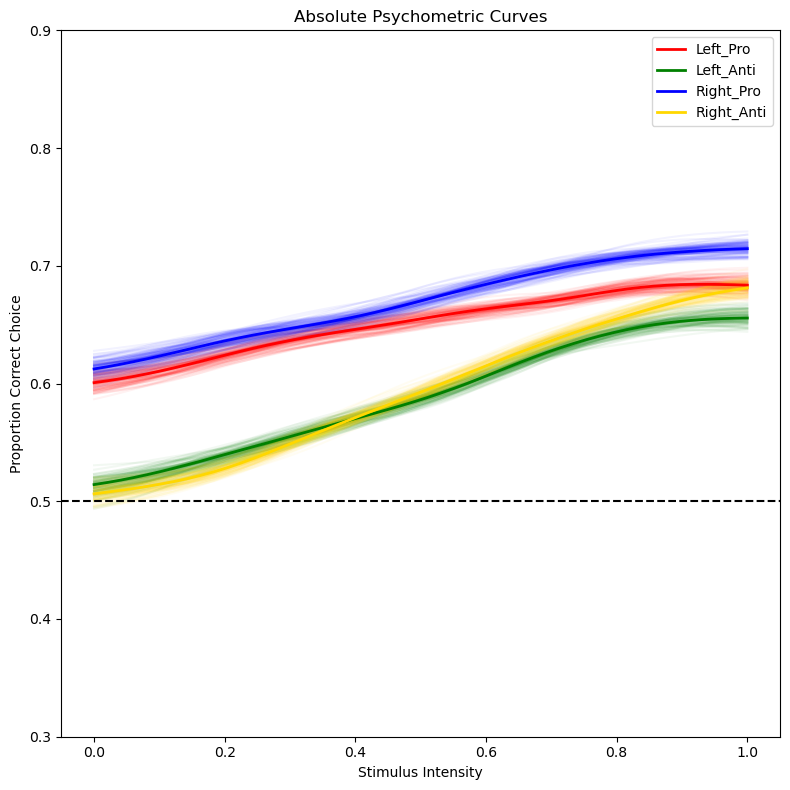

In [ ]:
x_range_dict = {'Left_Pro': (-1), 'Left_Anti': 1, 'Right_Pro': (-1), 'Right_Anti': 1}
choice_dict = {'Left_Pro': False, 'Left_Anti': True, 'Right_Pro': True, 'Right_Anti': False}
color_dict = {'Left_Pro': 'r', 'Left_Anti': 'g', 'Right_Pro': 'b', 'Right_Anti': 'gold'}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for tensor, color in zip([kde_L_below_0_boot_tensor, kde_L_above_0_boot_tensor, kde_R_below_0_boot_tensor, kde_R_above_0_boot_tensor], 
                         ['r', 'g', 'b', 'gold']):
    for i in range(boots_per_iter):
        for j in range(num_iterations):
            ax.plot(x_range, tensor[j][i], alpha=0.05, color = color)
        
for side in sub_df.Air_Puff_Side.unique():
    for contingency in sub_df.Air_Puff_Contingency.unique():
        contingency_df = sub_df[(sub_df.Air_Puff_Side == side) & (sub_df.Air_Puff_Contingency == contingency)]
        if choice_dict[side + '_' + contingency]:
            c = contingency_df.choice.values
        else:
            c = (1 - contingency_df.choice.values) 
        kde = compute_kde(x_range * x_range_dict[side + '_' + contingency],
                          contingency_df.Stim_Relative.values, c)
        ax.plot(x_range, kde, color=color_dict[side + '_' + contingency], linestyle='-', linewidth=2, label=side + '_' + contingency)

ax.set_ylim(0.3, 0.9)
ax.axhline(y=0.5, color='black', linestyle='--')
ax.set_title('Absolute Psychometric Curves')
ax.set_xlabel('Stimulus Intensity')
ax.set_ylabel('Proportion Correct Choice')
ax.legend()
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


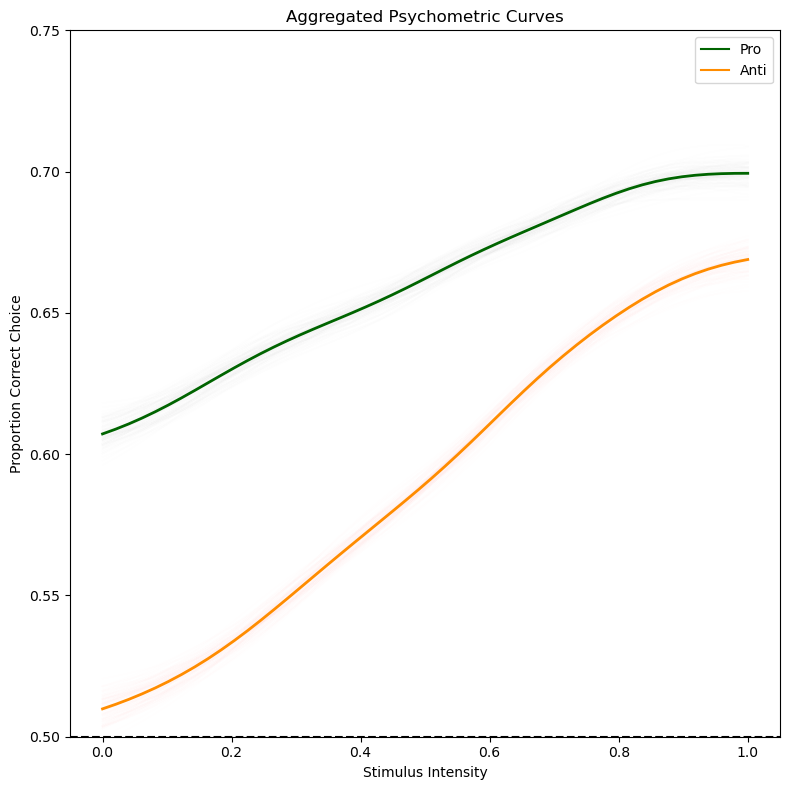

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

kde_Pro_boot_tensor = (kde_L_below_0_boot_tensor + kde_R_below_0_boot_tensor) / 2
kde_Anti_boot_tensor = (kde_L_above_0_boot_tensor + kde_R_above_0_boot_tensor) / 2

# Plot bootstraps
for tensor, color in zip([kde_Pro_boot_tensor, kde_Anti_boot_tensor], ['darkgreen', 'darkorange']):
    for i in range(boots_per_iter):
        for j in range(num_iterations):
            ax.plot(x_range, tensor[j][i], alpha=0.0025, color=color)

    # plot the mean of the bootstraps
    ax.plot(x_range, np.mean(tensor, axis=(0,1)), color=color, linestyle='-', linewidth=2)

# Set plot attributes
ax.set_ylim(0.5, 0.75) 
ax.axhline(y=0.5, color='black', linestyle='--')
ax.set_title('Aggregated Psychometric Curves')
ax.set_xlabel('Stimulus Intensity')
ax.set_ylabel('Proportion Correct Choice')
# remove any legend present
ax.legend().remove()
# make custom legend that says that red is pro and green is anti
ax.plot([], [], color='darkgreen', label='Pro')
ax.plot([], [], color='darkorange', label='Anti')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Initialize an empty DataFrame
results_df = pd.DataFrame(columns=['Participant_ID', 'Date', 
                                   'pro_125_perf', 'anti_125_perf', 'diff_125_perf',
                                   'pro_875_perf', 'anti_875_perf', 'diff_875_perf'])

for p_id in sub_df.Participant_ID.unique():
    participant_df = sub_df[sub_df.Participant_ID == p_id]
    for date in participant_df.Date.unique():
        date_df = participant_df[participant_df.Date == date]
        pro_df = date_df[date_df.Air_Puff_Contingency == 'Pro']
        anti_df = date_df[date_df.Air_Puff_Contingency == 'Anti']

        # Calculating performances
        pro_125_perf = pro_df[pro_df.stim_relative_binned == -0.125].correct.mean()
        anti_125_perf = anti_df[anti_df.stim_relative_binned == 0.125].correct.mean()
        pro_875_perf = pro_df[pro_df.stim_relative_binned == -0.875].correct.mean()
        anti_875_perf = anti_df[anti_df.stim_relative_binned == 0.875].correct.mean()

        # Calculating differences
        diff_125_perf = pro_125_perf - anti_125_perf
        diff_875_perf = pro_875_perf - anti_875_perf

        # Append to DataFrame
        results_df = results_df.append({'Participant_ID': p_id, 'Date': date,
                                        'pro_125_perf': pro_125_perf, 'anti_125_perf': anti_125_perf, 'diff_125_perf': diff_125_perf,
                                        'pro_875_perf': pro_875_perf, 'anti_875_perf': anti_875_perf, 'diff_875_perf': diff_875_perf}, 
                                       ignore_index=True)

# Optionally convert Date to datetime and sort
results_df['Date'] = pd.to_datetime(results_df['Date'])
results_df.sort_values(by=['Participant_ID', 'Date'], inplace=True)

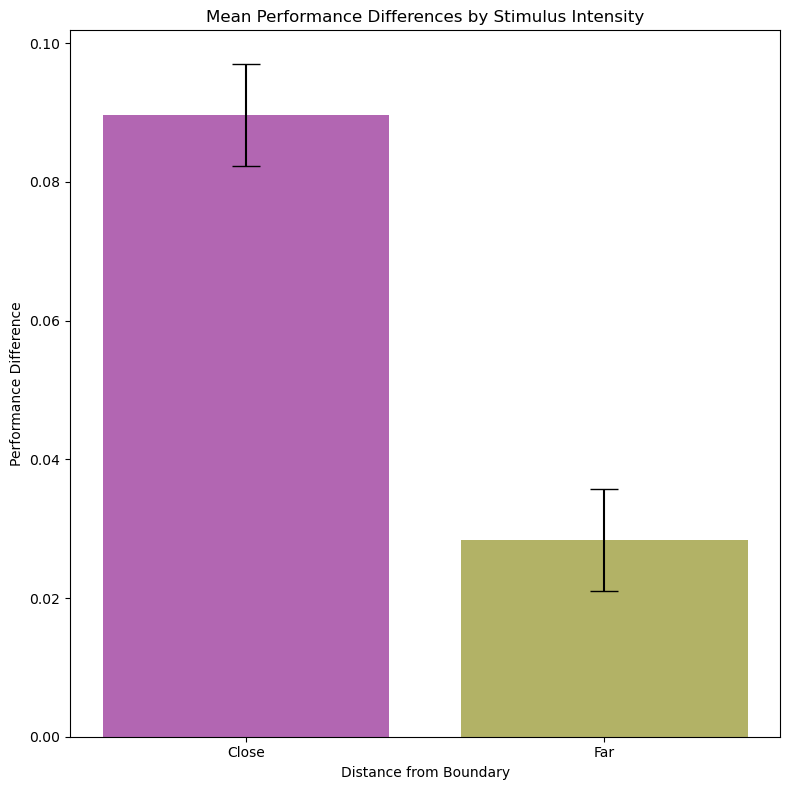

In [ ]:
mean_diff_125 = results_df['diff_125_perf'].mean()
mean_diff_875 = results_df['diff_875_perf'].mean()
sem_diff_125 = results_df['diff_125_perf'].sem()
sem_diff_875 = results_df['diff_875_perf'].sem()

# Creating the bar plot with error bars
plt.figure(figsize=(8, 8))

bar_heights = [mean_diff_125, mean_diff_875]
bar_labels = ['Mean Diff 0.125', 'Mean Diff 0.875']
bar_positions = [1, 2]

# Plotting bars with error bars
plt.bar(bar_positions, bar_heights, yerr=[sem_diff_125, sem_diff_875], color=['purple', 'olive'], alpha=0.6, label='Mean Performance', capsize=10)

# Customizing plot
plt.xticks(bar_positions, bar_labels)
plt.xlabel('Distance from Boundary')
plt.ylabel('Performance Difference')
plt.title('Mean Performance Differences by Stimulus Intensity')
plt.xticks([1, 2], ['Close', 'Far'])
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Performing a t-test to compare the diff_125_perf and diff_875_perf
X = results_df['diff_125_perf'].dropna()
Y = results_df['diff_875_perf'].dropna()
t_stat, p_value = ttest_ind(X, Y)

t_stat, p_value

(5.924900400451861, 5.011398732336351e-09)

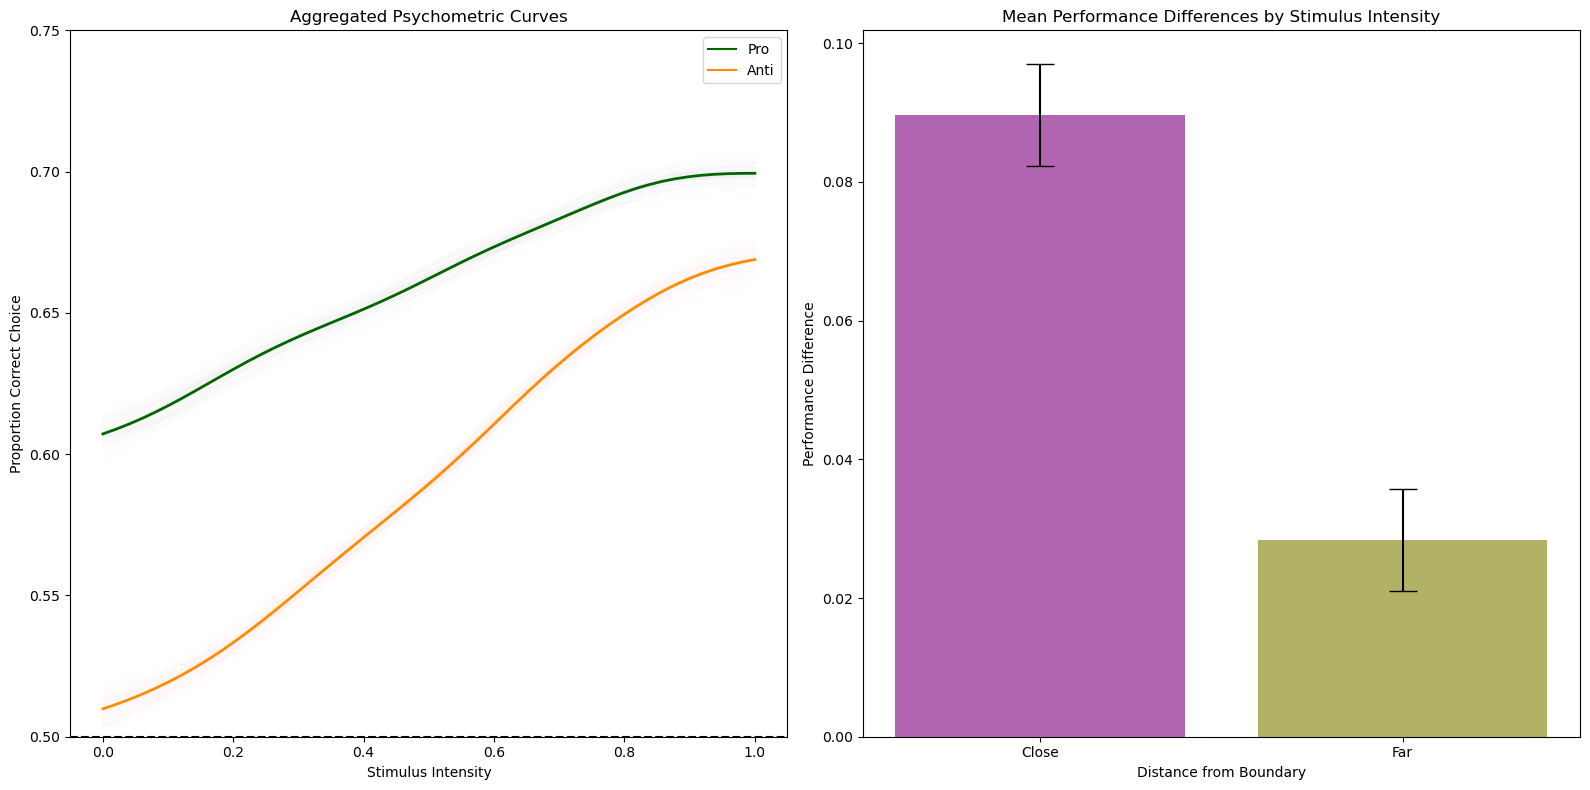

In [ ]:
# Create a 8x8 figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# First subplot: Aggregated Psychometric Curves
for tensor, color in zip([kde_Pro_boot_tensor, kde_Anti_boot_tensor], ['darkgreen', 'darkorange']):
    for i in range(boots_per_iter):
        for j in range(num_iterations):
            ax1.plot(x_range, tensor[j][i], alpha=0.0025, color=color)

    # plot the mean of the bootstraps
    ax1.plot(x_range, np.mean(tensor, axis=(0,1)), color=color, linestyle='-', linewidth=2)

ax1.set_ylim(0.5, 0.75)
ax1.axhline(y=0.5, color='black', linestyle='--')
ax1.set_title('Aggregated Psychometric Curves')
ax1.set_xlabel('Stimulus Intensity')
ax1.set_ylabel('Proportion Correct Choice')
ax1.plot([], [], color='darkgreen', label='Pro')
ax1.plot([], [], color='darkorange', label='Anti')
ax1.legend()

# Second subplot: Bar plot with error bars
bar_heights = [mean_diff_125, mean_diff_875]
bar_labels = ['Mean Diff 0.125', 'Mean Diff 0.875']
bar_positions = [1, 2]

ax2.bar(bar_positions, bar_heights, yerr=[sem_diff_125, sem_diff_875], color=['purple', 'olive'], alpha=0.6, label='Mean Performance', capsize=10)
ax2.set_xticks(bar_positions, bar_labels)
ax2.set_xlabel('Distance from Boundary')
ax2.set_ylabel('Performance Difference')
ax2.set_title('Mean Performance Differences by Stimulus Intensity')
ax2.set_xticks([1, 2], ['Close', 'Far'])

plt.tight_layout()
plt.show()

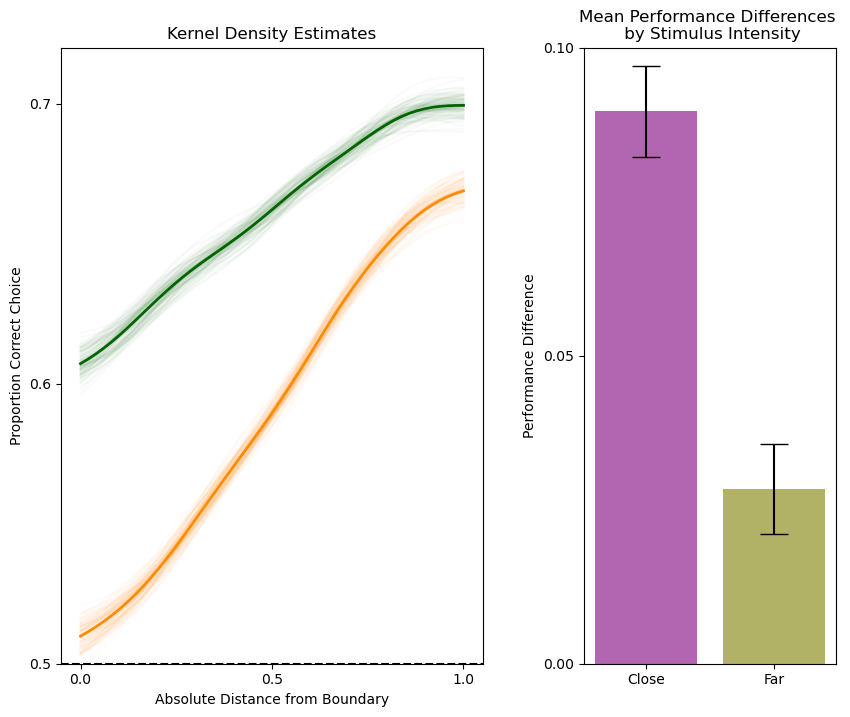

In [ ]:
# Create gridspec
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5/8, 3/8]}, figsize=(10, 8))

# Plotting for the first subplot
for tensor, color in zip([kde_Pro_boot_tensor, kde_Anti_boot_tensor], ['darkgreen', 'darkorange']):
    for i in range(boots_per_iter):
        for j in range(num_iterations):
            ax1.plot(x_range, tensor[j][i], alpha=0.025, color=color)

    ax1.plot(x_range, np.mean(tensor, axis=(0,1)), color=color, linestyle='-', linewidth=2)

ax1.axhline(y=0.5, color='black', linestyle='--')
ax1.set_title('Kernel Density Estimates')
ax1.set_xlabel('Absolute Distance from Boundary')
ax1.set_ylabel('Proportion Correct Choice')
# ax1.set_yticks([0.5, 0.75])
ax1.plot([], [], color='darkgreen', label='Pro')
ax1.plot([], [], color='darkorange', label='Anti')
ax1.set_yticks([0.5, 0.6, 0.7, 0.8])
ax1.set_ylim(0.5, 0.72)
ax1.set_xticks([0, 0.5, 1])
# ax1.legend().remove()
# x_pos, y_start, y_length = 0.125, 0.55, 0.055
# ax1.annotate('', xy=(x_pos, y_start), xytext=(x_pos, y_start + y_length),
#                  arrowprops=dict(arrowstyle="<->", color='purple', linewidth=2))
# x_pos, y_start, y_length = 0.875, 0.665, 0.02
# ax1.annotate('', xy=(x_pos, y_start), xytext=(x_pos, y_start + y_length),
#                  arrowprops=dict(arrowstyle="<->", color='olive', linewidth=2))


# Plotting for the second subplot
ax2.bar(bar_positions, bar_heights, yerr=[sem_diff_125, sem_diff_875], color=['purple', 'olive'], alpha=0.6, label='Mean Performance', capsize=10)
ax2.set_xticks(bar_positions)
ax2.set_ylim(0, 0.1)
ax2.set_xticklabels(['Close', 'Far'])
ax2.set_xlabel(' ')
ax2.set_ylabel('Performance Difference')
ax2.set_title('Mean Performance Differences \n by Stimulus Intensity')
ax2.set_yticks([0, 0.05, 0.1])
# Adding a line to show statistical significance
x_values = [1, 2]
y_values = [0.09, 0.09]
# ax2.plot(x_values, y_values, color='black')
# ax2.text(1.5, y_values[0] - 0.003, "*", ha='center', va='bottom', color='black', fontsize=30)

# Adjust the spacing
plt.subplots_adjust(wspace=0.3)  # Adjust the width space between the subplots
plt.savefig(figs_path + 'KDEs_and_perf_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# date = '2023/12/20'
# for p_id in Animal_List:
#     sub_df = df[(df['Participant_ID'] == p_id) & (df['Date'] == date)]
#     sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
#     fig, ax = plt.subplots(1, 1, figsize=(20, 10))
#     ax.plot(sub_df.index, sub_df['correct'].rolling(30).mean(), color='g', label='Performance')
#     ax.plot(sub_df.index, ((sub_df['Choice_Rule_Diff']+1)/2).rolling(30).mean(), color='r', label='Bias')
#     ax.set_xlabel('Trial Number')
#     ax.set_ylabel('Correct')
#     ax.set_title(p_id + ', ' + date)
#     ax.axhline(0.5, color='k', linestyle='--')
#     ax.set_ylim([0, 1])
#     ax.set_xlim([0, len(sub_df)+10])
#     ax.legend()
#     plt.show()


In [ ]:
# # isolate for QP0108 on 2023/12/07
# sub_df = df[(df['Participant_ID'] == 'QP0108') & (df['Date'] == '2023/12/07')]
# # print all unique stim_relative values
# print(sub_df['Stim_Relative'].unique())

In [ ]:
# p_id = 'QP083'
# participant_df = df[df['Participant_ID'] == p_id]
# # grab last 4 dates of participant
# dates = participant_df['Date'].unique()[-5:]
# for date in dates:
#     # only keep data in dates
#     fig, ax = plt.subplots(1, 1, figsize=(20, 10))

#     date_df = participant_df[participant_df['Date'] == date]
#     date_df = date_df[date_df['No_response'] == False].reset_index(drop=True)
#     ax.plot(date_df.index, date_df['correct'].rolling(30).mean(), color='g', label='Performance')
#     ax.plot(date_df.index, ((date_df['Choice_Rule_Diff']+1)/2).rolling(30).mean(), color='r', label='Bias')
#     ax.set_xlabel('Trial Number')
#     ax.set_ylabel('Correct')
#     ax.set_title(p_id + ', ' + date)
#     ax.axhline(0.5, color='k', linestyle='--')
#     ax.set_ylim([0, 1])
#     ax.set_xlim([0, len(date_df)+10])
#     ax.legend()
#     plt.show()

## Effect of different working memory delays on performance

In [19]:
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    '''
    Calculate the confidence interval for the mean of a dataset using bootstrapping.
    Args:
        data (array): The data to use.
        n_bootstrap (int): The number of bootstrap samples to use.
        ci (int): The confidence interval to use.
    Returns:
        lower_bound (float): The lower bound of the confidence interval.
        upper_bound (float): The upper bound of the confidence interval.
    '''
    bootstrapped_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrapped_means.append(np.mean(sample))
    lower_bound = np.percentile(bootstrapped_means, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_means, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound

def remove_consecutive_aborts(group, threshold=30):
    """
    Removes consecutive aborts from a group.
    Args:
        group (pd.DataFrame): The group to remove consecutive aborts from.
        threshold (int): The threshold for consecutive aborts.
    Returns:
        group (pd.DataFrame): The group with consecutive aborts removed.
    """
    # Identify the start of consecutive aborts
    group['start_consecutive_abort'] = (group['Abort_Trial'] == 1) & (group['Abort_Trial'].shift(1) != 1)

    # Cumulative sum to identify unique sequences
    group['consecutive_group'] = group['start_consecutive_abort'].cumsum()

    # Count aborts in each consecutive sequence
    abort_counts = group.groupby('consecutive_group')['Abort_Trial'].transform('sum')

    # Mark rows to keep (not part of a sequence of 30+ aborts)
    group['keep'] = ~((group['Abort_Trial'] == 1) & (abort_counts >= threshold))

    return group[group['keep']]

In [ ]:
subj = 'QP0108'
dates = [
         '2023/11/09',
         '2023/11/10',
         '2023/11/11',
         '2023/11/13',
         '2023/11/14',
         '2023/11/15',
         '2023/11/16',
         '2023/11/17',
         ]
sub_df = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates))]
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
sub_df['Working_Memory_Delay'] = sub_df['Working_Memory_Delay'].fillna('00:00:00.5000000')

In [ ]:
# p_ids = ['QP083', 'QP084', 'QP085']
# date_lim = '2024/01/17'
# sub_df = df[(df['Date'] >= date_lim) & (df['Participant_ID'].isin(p_ids))].reset_index(drop=True)
# sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
# sub_df['Working_Memory_Delay'] = sub_df['Working_Memory_Delay'].fillna('00:00:00.5000000')

In [ ]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# color_dict = {
#     'Left': 'b',
#     'Right': 'r'
# }

# for side in sub_df.Air_Puff_Side.unique():
#     side_df = sub_df[sub_df['Air_Puff_Side'] == side]
#     sns.pointplot(x=side_df.stim_relative_binned, y='choice', 
#                 data=side_df, capsize=0.1, ax=ax, ci=95, color=color_dict[side])

# ax.set_ylim(0, 1)
# ax.axhline(y=0.5, color='black', linestyle='--')
# ax.set_title('Psychometric Curve')
# ax.set_xlabel('Stimulus Intensity')
# # ax.set_ylabel('Proportion Correct Choice')
# plt.tight_layout()
# plt.show()

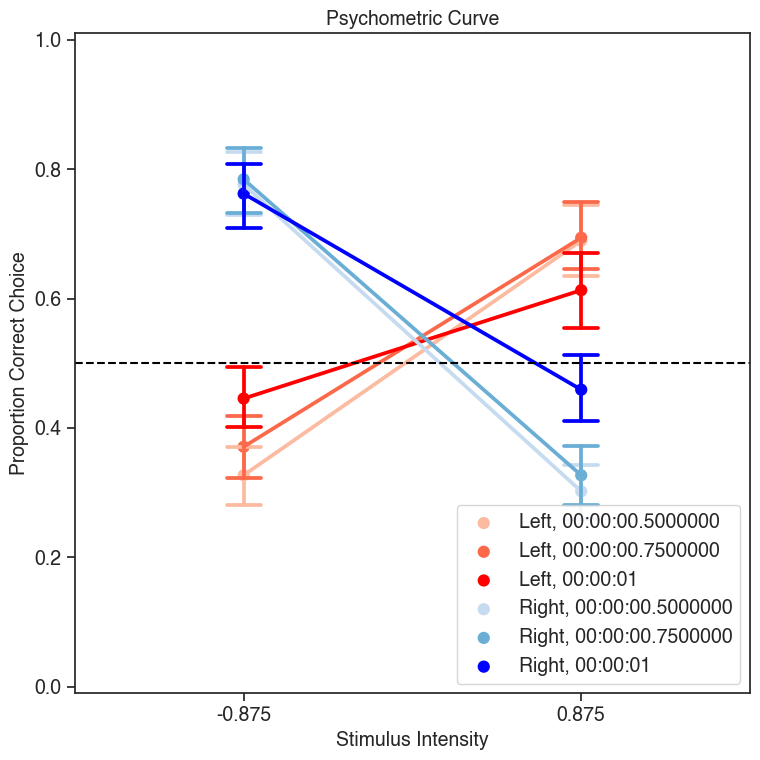

In [ ]:
# Generating a dynamic color dictionary based on unique values of Air_Puff_Side and Working_Memory_Delay

# Getting unique values and sorting them to ensure consistency
unique_sides = sorted(sub_df['Air_Puff_Side'].unique())
unique_delays = sorted(sub_df['Working_Memory_Delay'].unique())

# Adjusting color maps for a softer gradient
color_maps = {
    'Left': sns.color_palette("Reds", len(unique_delays))[:-1] + [sns.dark_palette("red", n_colors=1, reverse=True)[0]],  
    'Right': sns.color_palette("Blues", len(unique_delays))[:-1] + [sns.dark_palette("blue", n_colors=1, reverse=True)[0]]
}


# Creating the color dictionary
color_dict = {}
for side in unique_sides:
    for i, delay in enumerate(unique_delays):
        color_dict[f'{side}, {delay}'] = color_maps[side][i]

# Plotting the data
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for side in unique_sides:
    for wm_dur in unique_delays:
        subset_df = sub_df[(sub_df['Air_Puff_Side'] == side) & (sub_df['Working_Memory_Delay'] == wm_dur)]
        sns.pointplot(x='stim_relative_binned', y='choice', 
                      data=subset_df, capsize=0.1, ax=ax, ci=95, 
                      label=f'{side}, {wm_dur}', color=color_dict[f'{side}, {wm_dur}'])

ax.legend(loc='lower right')
ax.set_ylim(-0.01, 1.01)
ax.axhline(y=0.5, color='black', linestyle='--')
ax.set_title('Psychometric Curve')
ax.set_xlabel('Stimulus Intensity')
ax.set_ylabel('Proportion Correct Choice')

plt.tight_layout()
plt.show()


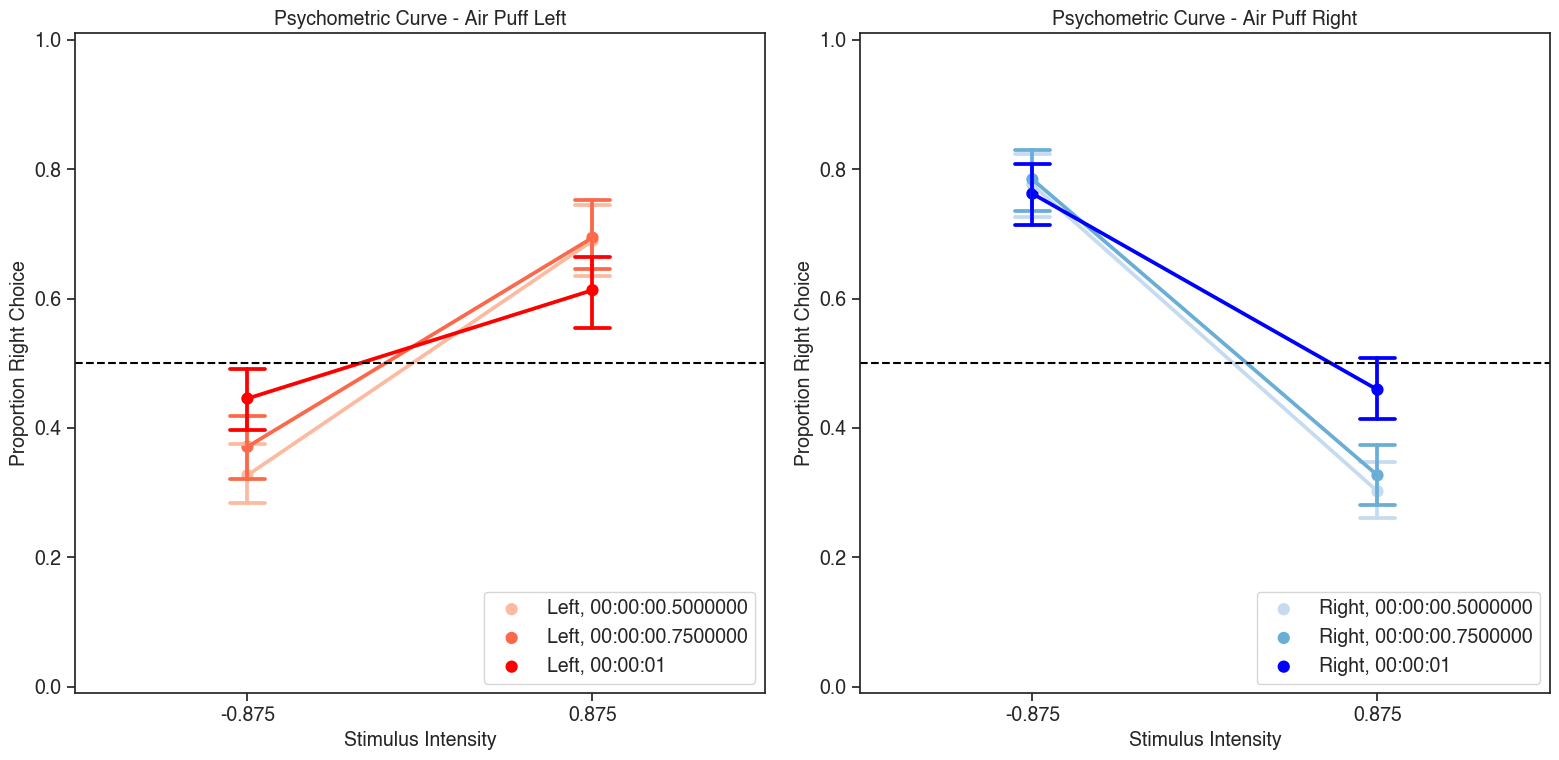

In [ ]:
# Creating two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plotting 'Air Puff Left' data
for wm_dur in unique_delays:
    subset_df_left = sub_df[(sub_df['Air_Puff_Side'] == 'Left') & (sub_df['Working_Memory_Delay'] == wm_dur)]
    sns.pointplot(x='stim_relative_binned', y='choice', data=subset_df_left, 
                  capsize=0.1, ax=axes[0], ci=95, 
                  label=f'Left, {wm_dur}', color=color_dict[f'Left, {wm_dur}'])

axes[0].legend(loc='lower right')
axes[0].set_ylim(-0.01, 1.01)
axes[0].axhline(y=0.5, color='black', linestyle='--')
axes[0].set_title('Psychometric Curve - Air Puff Left')
axes[0].set_xlabel('Stimulus Intensity')
axes[0].set_ylabel('Proportion Right Choice')

# Plotting 'Air Puff Right' data
for wm_dur in unique_delays:
    subset_df_right = sub_df[(sub_df['Air_Puff_Side'] == 'Right') & (sub_df['Working_Memory_Delay'] == wm_dur)]
    sns.pointplot(x='stim_relative_binned', y='choice', data=subset_df_right, 
                  capsize=0.1, ax=axes[1], ci=95, 
                  label=f'Right, {wm_dur}', color=color_dict[f'Right, {wm_dur}'])

axes[1].legend(loc='lower right')
axes[1].set_ylim(-0.01, 1.01)
axes[1].axhline(y=0.5, color='black', linestyle='--')
axes[1].set_title('Psychometric Curve - Air Puff Right')
axes[1].set_xlabel('Stimulus Intensity')
axes[1].set_ylabel('Proportion Right Choice')

plt.tight_layout()
plt.show()


In [ ]:
# desired_order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']
# sub_df.Working_Memory_Delay = pd.Categorical(sub_df.Working_Memory_Delay, categories=desired_order, ordered=True)


# df_left_pro = sub_df[(sub_df['Air_Puff_Side'] == 'Left') & (sub_df['Air_Puff_Contingency'] == 'Pro')]
# df_left_anti = sub_df[(sub_df['Air_Puff_Side'] == 'Left') & (sub_df['Air_Puff_Contingency'] == 'Anti')]
# df_right_pro = sub_df[(sub_df['Air_Puff_Side'] == 'Right') & (sub_df['Air_Puff_Contingency'] == 'Pro')]
# df_right_anti = sub_df[(sub_df['Air_Puff_Side'] == 'Right') & (sub_df['Air_Puff_Contingency'] == 'Anti')]

# # For df_right_pro and df_right_anti, use 'choice' directly
# ci_right_pro = df_right_pro.groupby('Working_Memory_Delay')['choice'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))
# ci_right_anti = df_right_anti.groupby('Working_Memory_Delay')['choice'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))

# # For df_left_pro and df_left_anti, use '1 - choice'
# ci_left_pro = df_left_pro.groupby('Working_Memory_Delay')['choice'].apply(lambda x: bootstrap_ci(1 - x, n_bootstrap=1000, ci=95))
# ci_left_anti = df_left_anti.groupby('Working_Memory_Delay')['choice'].apply(lambda x: bootstrap_ci(1 - x, n_bootstrap=1000, ci=95))

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# # Plotting data without CI
# sns.pointplot(x='Working_Memory_Delay', y='choice', data=df_right_pro, ax=ax, ci=None, color='b', label='Pro - Air Puff Right')
# sns.pointplot(x='Working_Memory_Delay', y='choice', data=df_right_anti, ax=ax, ci=None, color='r', label='Anti - Air Puff Right')
# sns.pointplot(x='Working_Memory_Delay', y=(1 - df_left_pro['choice']), data=df_left_pro, ax=ax, ci=None, color='g', label='Pro - Air Puff Left')
# sns.pointplot(x='Working_Memory_Delay', y=(1 - df_left_anti['choice']), data=df_left_anti, ax=ax, ci=None, color='m', label='Anti - Air Puff Left')

# # Manually adding error bars for all conditions
# for i, delay in enumerate(desired_order):
#     # For df_right_pro
#     y_value_pro_right = df_right_pro[df_right_pro['Working_Memory_Delay'] == delay]['choice'].mean()
#     lower_pro_right, upper_pro_right = ci_right_pro[delay]
#     plt.errorbar(i, y_value_pro_right, yerr=[[y_value_pro_right - lower_pro_right], [upper_pro_right - y_value_pro_right]], fmt='none', ecolor='b', capsize=5)

#     # For df_right_anti
#     y_value_anti_right = df_right_anti[df_right_anti['Working_Memory_Delay'] == delay]['choice'].mean()
#     lower_anti_right, upper_anti_right = ci_right_anti[delay]
#     plt.errorbar(i, y_value_anti_right, yerr=[[y_value_anti_right - lower_anti_right], [upper_anti_right - y_value_anti_right]], fmt='none', ecolor='r', capsize=5)

#     # For df_left_pro
#     y_value_pro_left = (1 - df_left_pro[df_left_pro['Working_Memory_Delay'] == delay]['choice']).mean()
#     lower_pro_left, upper_pro_left = ci_left_pro[delay]
#     plt.errorbar(i, y_value_pro_left, yerr=[[y_value_pro_left - lower_pro_left], [upper_pro_left - y_value_pro_left]], fmt='none', ecolor='g', capsize=5)

#     # For df_left_anti
#     y_value_anti_left = (1 - df_left_anti[df_left_anti['Working_Memory_Delay'] == delay]['choice']).mean()
#     lower_anti_left, upper_anti_left = ci_left_anti[delay]
#     plt.errorbar(i, y_value_anti_left, yerr=[[y_value_anti_left - lower_anti_left], [upper_anti_left - y_value_anti_left]], fmt='none', ecolor='m', capsize=5)

# plt.ylim(0, 1)
# plt.axhline(y=0.5, color='black', linestyle='--')
# plt.ylabel('Proportion Pro Choice')
# plt.xlabel('Working Memory Delay (s)')
# plt.xticks([0, 1, 2], ['0.5', '0.75', '1'])
# plt.legend()
# plt.tight_layout()
# plt.show()


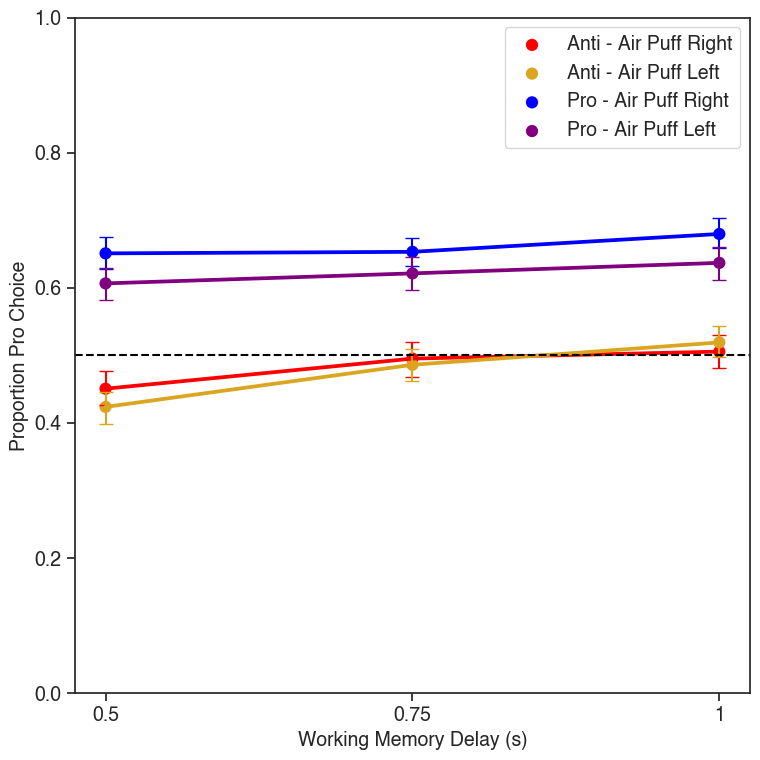

In [ ]:
desired_order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']
sub_df.Working_Memory_Delay = pd.Categorical(sub_df.Working_Memory_Delay, categories=desired_order, ordered=True)

# Define the conditions
conditions = [
    (sub_df['Air_Puff_Contingency'] == 'Pro') & (sub_df['Air_Puff_Side'] == 'Right'),
    (sub_df['Air_Puff_Contingency'] == 'Pro') & (sub_df['Air_Puff_Side'] == 'Left'),
    (sub_df['Air_Puff_Contingency'] == 'Anti') & (sub_df['Air_Puff_Side'] == 'Right'),
    (sub_df['Air_Puff_Contingency'] == 'Anti') & (sub_df['Air_Puff_Side'] == 'Left')
]

# Define the choices for each condition
choices = [
          sub_df['choice'],           # Pro and Right
          1 - sub_df['choice'],       # Pro and Left
          sub_df['choice'],           # Anti and Right
          1 - sub_df['choice']        # Anti and Left
]

# Create the new column
sub_df['Pro_Choice'] = np.select(conditions, choices, default=np.nan)

color_dict = {
    'Pro_Left': 'purple',
    'Pro_Right': 'blue',
    'Anti_Left': 'goldenrod',
    'Anti_Right': 'red'
}

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

for contingency in sub_df.Air_Puff_Contingency.unique():
    for side in sub_df.Air_Puff_Side.unique():
        side_contingency_df = sub_df[(sub_df['Air_Puff_Contingency'] == contingency) & (sub_df['Air_Puff_Side'] == side)]
        label = f'{contingency} - Air Puff {side}'
        # color = 'b' if side == 'Right' else 'g'  # Choose colors as per your preference

        # Calculate CI
        ci_values = side_contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))

        # Plot data without CI
        sns.pointplot(x='Working_Memory_Delay', y='Pro_Choice', data=side_contingency_df, ax=ax, ci=None, 
                      color=color_dict[contingency + '_' + side],
                      label=label)

        # Manually adding error bars
        for i, delay in enumerate(desired_order):
            y_value = side_contingency_df[side_contingency_df['Working_Memory_Delay'] == delay]['Pro_Choice'].mean()
            lower, upper = ci_values[delay]
            plt.errorbar(i, y_value, yerr=[[y_value - lower], [upper - y_value]], fmt='none', 
                         ecolor=color_dict[contingency + '_' + side],
                         capsize=5)

plt.ylim(0, 1)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.ylabel('Proportion Pro Choice')
plt.xlabel('Working Memory Delay (s)')
plt.xticks([0, 1, 2], ['0.5', '0.75', '1'])
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# # now make the same plot, just seperating by contingency
# color_dict = {
#     'Pro': 'darkgreen',
#     'Anti': 'darkorange'
# }

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# for contingency in sub_df.Air_Puff_Contingency.unique():
#     contingency_df = sub_df[sub_df['Air_Puff_Contingency'] == contingency]
#     label = f'{contingency}'
#     # color = 'b' if side == 'Right' else 'g'  # Choose colors as per your preference

#     # Calculate CI
#     ci_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))

#     # Plot data without CI
#     sns.pointplot(x='Working_Memory_Delay', y='Pro_Choice', data=contingency_df, ax=ax, ci=None, 
#                   color=color_dict[contingency],
#                   label=label)

#     # Manually adding error bars
#     for i, delay in enumerate(desired_order):
#         y_value = contingency_df[contingency_df['Working_Memory_Delay'] == delay]['Pro_Choice'].mean()
#         lower, upper = ci_values[delay]
#         plt.errorbar(i, y_value, yerr=[[y_value - lower], [upper - y_value]], fmt='none', 
#                      ecolor=color_dict[contingency],
#                      capsize=5)
        
# plt.ylim(0, 1)
# plt.axhline(y=0.5, color='black', linestyle='--')
# plt.ylabel('Proportion Pro Choice')
# plt.xlabel('Working Memory Delay (s)')
# plt.xticks([0, 1, 2], ['0.5', '0.75', '1'])
# legend_labels = ['Pro', 'Anti']

# legend_colors = [color_dict[label] for label in legend_labels]

# # Create a custom legend with specified labels and colors
# # custom_legend = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]
# # custom_legend = [Line2D([0], [0], color=color, lw=12, label=label) for label, color in zip(legend_labels, legend_colors)]
# custom_legend = [mpatches.Patch(color=color, label=label) for label, color in zip(legend_labels, legend_colors)]

# plt.legend(handles=custom_legend, title="Contingency")  # Add the custom legend with a title

# plt.tight_layout()
# plt.show()

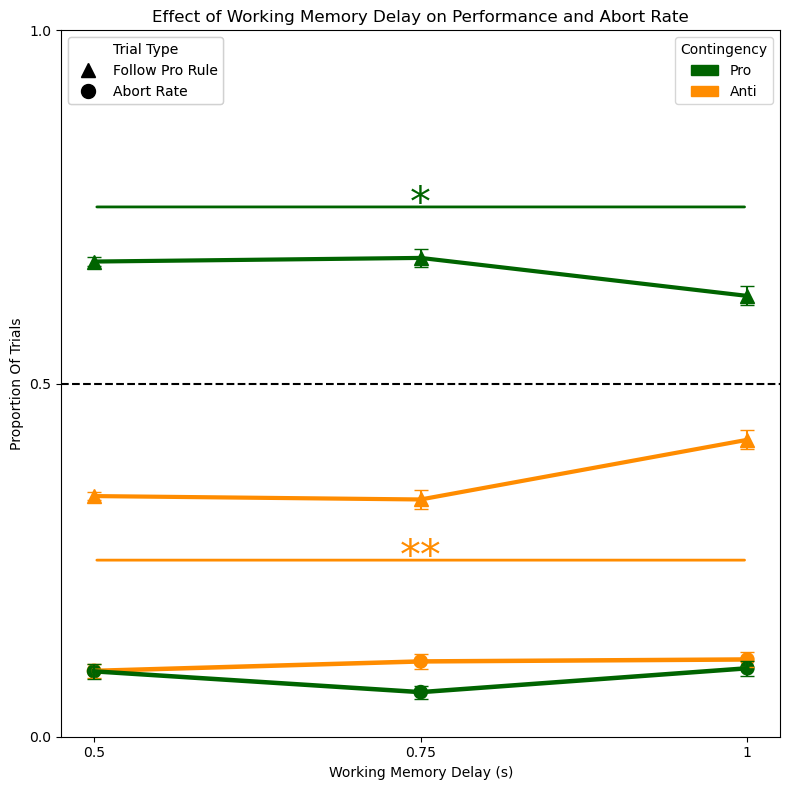

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

marker_dict = { 
    'Pro_Rate': '^',
    'Abort_Rate': 'o',
}

color_dict = {
    'Pro': 'darkgreen',
    'Anti': 'darkorange'
}

for i, contingency in enumerate(sub_df.Air_Puff_Contingency.unique()):
    contingency_df = sub_df[sub_df['Air_Puff_Contingency'] == contingency]
    label = f'{contingency}'

    # Calculate CI
    # ci_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))
    sem_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].sem()

    # Manually plot data with triangles as markers
    x_values = np.arange(len(desired_order))  # Shift x-values to separate Pro and Anti
    y_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].mean()
    
    plt.plot(x_values, y_values, marker=marker_dict['Pro_Rate'], linestyle='-', 
             color=color_dict[contingency], label=label, markersize=10,
                linewidth=3)

    # Manually adding error bars
    for j, delay in enumerate(desired_order):
        y_value = y_values[desired_order[j]]
        sem_value = sem_values[desired_order[j]]
        # lower, upper = ci_values[delay]
        # lower, upper = y_value - sem_value, y_value + sem_value
        plt.errorbar(x_values[j], y_value, yerr=[[sem_value], [sem_value]], fmt='none', 
                     ecolor=color_dict[contingency],
                     capsize=5)
        
sub_df_abort = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates))].reset_index(drop=True)
sub_df_abort['Abort_Trial'] = sub_df_abort['No_response'].astype(int)
desired_order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']
sub_df_abort.Working_Memory_Delay = pd.Categorical(sub_df_abort.Working_Memory_Delay, categories=desired_order, ordered=True)

# remove rows if they are 30 consecutive aborts or more
sub_df_abort = sub_df_abort.groupby(['Participant_ID', 'Date']).apply(remove_consecutive_aborts).reset_index(drop=True)
sub_df_abort.drop(['start_consecutive_abort', 'consecutive_group', 'keep'], axis=1, inplace=True)

for contingency in sub_df_abort.Air_Puff_Contingency.unique():
    contingency_df = sub_df_abort[sub_df_abort['Air_Puff_Contingency'] == contingency]
    label = f'{contingency}'
    # color = 'b' if side == 'Right' else 'g'  # Choose colors as per your preference

    # Calculate CI
    # ci_values = contingency_df.groupby('Working_Memory_Delay')['Abort_Trial'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))
    sem = contingency_df.groupby('Working_Memory_Delay')['Abort_Trial'].sem()
    # Plot data without CI
    sns.pointplot(x='Working_Memory_Delay', y='Abort_Trial', data=contingency_df, ax=ax, ci=None, 
                  color=color_dict[contingency],
                  label=label, scale=1.2)


    # Manually adding error bars
    for i, delay in enumerate(desired_order):
        y_value = contingency_df[contingency_df['Working_Memory_Delay'] == delay]['Abort_Trial'].mean()
        # lower, upper = ci_values[delay]
        sem_value = sem[delay]

        plt.errorbar(i, y_value, yerr=[[sem_value], [sem_value]], fmt='none', 
                     ecolor=color_dict[contingency],
                     capsize=5)
        
plt.ylim(0, 1)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.ylabel('Proportion Of Trials')

plt.xlabel('Working Memory Delay (s)')
plt.xticks([0, 1, 2], ['0.5', '0.75', '1'])
plt.yticks (np.arange(0, 1.1, 0.5))
contingency_legend_labels = ['Pro', 'Anti']
contingency_legend_colors = [color_dict[label] for label in contingency_legend_labels]
contingency_legend = [mpatches.Patch(color=color, label=label) for label, color in zip(contingency_legend_labels, contingency_legend_colors)]

marker_legend_labels = ['Pro_Rate', 'Abort_Rate']
larker_actual_labels = ['Follow Pro Rule', 'Abort Rate']
marker_legend_handles = [mlines.Line2D([], [], color='k', marker=marker_dict[label], linestyle='',
                                      markersize=10, label=new_label) for label, new_label in zip(marker_legend_labels, larker_actual_labels)]

# Create two separate legend instances
legend1 = plt.legend(handles=contingency_legend, title="Contingency", loc = 'upper right')
# legend2 = plt.legend(handles=marker_legend_handles, title="Trial Type", loc='upper left')  # Add the marker meanings legend

legend2 = plt.legend(handles=marker_legend_handles, title="Trial Type", loc='upper left')
x_start, y_pos, x_length = 0, 0.25, 2
ax.annotate('', xy=(x_start, y_pos), xytext=(x_start + x_length, y_pos),
             arrowprops=dict(arrowstyle="-", color='darkorange', linewidth=2))
ax.text(1, y_pos-0.025, "**", ha='center', va='bottom', color='darkorange', fontsize=30)
x_start, y_pos, x_length = 0, 0.75, 2
ax.annotate('', xy=(x_start, y_pos), xytext=(x_start + x_length, y_pos),
             arrowprops=dict(arrowstyle="-", color='darkgreen', linewidth=2))
ax.text(1, y_pos-0.025, "*", ha='center', va='bottom', color='darkgreen', fontsize=30)
# Add the legend instances to the plot
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.title('Effect of Working Memory Delay on Performance and Abort Rate')
plt.tight_layout()
plt.savefig(figs_path + 'Effect_of_WMD_on_Perf_and_Abort.pdf', dpi=300, bbox_inches='tight')
plt.show()



In [ ]:
results = []
for contingency in sub_df.Air_Puff_Contingency.unique():
    contingency_df = sub_df[sub_df['Air_Puff_Contingency'] == contingency]
    for wm_dur in contingency_df.Working_Memory_Delay.unique():
        wm_dur_contingency_df = contingency_df[contingency_df['Working_Memory_Delay'] == wm_dur]
        ci_lower, ci_upper = bootstrap_ci(wm_dur_contingency_df['Pro_Choice'], n_bootstrap=1000, ci=95)
        

        results.append({
            'Contingency': contingency,
            'WM_Dur': wm_dur,
            'Mean': wm_dur_contingency_df['Pro_Choice'].mean(),
            'SEM': wm_dur_contingency_df['Pro_Choice'].sem(),
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper
        })

results_df = pd.DataFrame(results)
order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']
results_df = results_df.sort_values(by='WM_Dur')

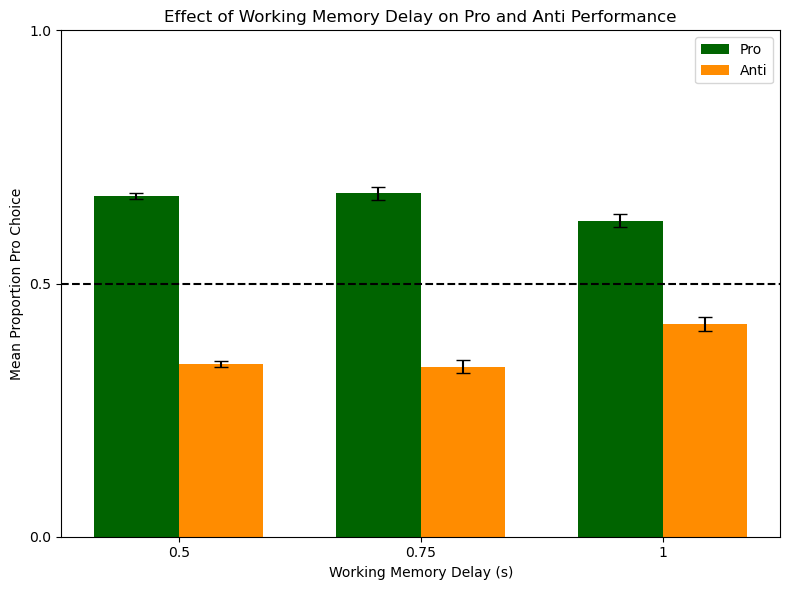

In [ ]:
pro_df = results_df[results_df['Contingency'] == 'Pro']
anti_df = results_df[results_df['Contingency'] == 'Anti']

# Plotting with calculated confidence intervals
fig, ax = plt.subplots(figsize=(8, 6))

# Bar positions
positions = np.arange(len(pro_df))
bar_width = 0.35

# Pro bars with error
# pro_errors = [pro_df['Mean'] - pro_df['CI_Lower'], pro_df['CI_Upper'] - pro_df['Mean']]
pro_errors = pro_df['SEM']
ax.bar(positions - bar_width/2, pro_df['Mean'], bar_width, yerr=pro_errors, label='Pro', color='darkgreen', capsize=5)

# Anti bars with error
# anti_errors = [anti_df['Mean'] - anti_df['CI_Lower'], anti_df['CI_Upper'] - anti_df['Mean']]
anti_errors = anti_df['SEM']
ax.bar(positions + bar_width/2, anti_df['Mean'], bar_width, yerr=anti_errors, label='Anti', color='darkorange', capsize=5)

# Setting the axes and labels
ax.set_xlabel('Working Memory Delay (s)')
ax.set_ylabel('Mean Proportion Pro Choice')
ax.set_title('Effect of Working Memory Delay on Pro and Anti Performance')
ax.set_xticks([0, 1, 2], ['0.5', '0.75', '1'])
ax.set_yticks(np.arange(0, 1.1, 0.5))
# ax.set_xticklabels(pro_df['WM_Dur'].unique())
ax.axhline(y=0.5, color='black', linestyle='--')

ax.set_ylim(0, 1)
ax.legend()

plt.tight_layout()
plt.show()



In [ ]:
results_by_date = []
for date in sub_df.Date.unique():
    date_df = sub_df[sub_df['Date'] == date]
    for contingency in date_df.Air_Puff_Contingency.unique():
        contingency_df = date_df[date_df['Air_Puff_Contingency'] == contingency]
        for wm_dur in contingency_df.Working_Memory_Delay.unique():
            wm_dur_contingency_df = contingency_df[contingency_df['Working_Memory_Delay'] == wm_dur]
            ci_lower, ci_upper = bootstrap_ci(wm_dur_contingency_df['Pro_Choice'], n_bootstrap=1000, ci=95)
            

            results_by_date.append({
                'Date': date,
                'Contingency': contingency,
                'WM_Dur': wm_dur,
                'Mean': wm_dur_contingency_df['Pro_Choice'].mean(),
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper
            })

    results_by_date_df = pd.DataFrame(results_by_date)
    order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']
    results_by_date_df = results_by_date_df.sort_values(by='WM_Dur')

In [ ]:
len(pro_05s), len(pro_1s)

(36, 14)

In [ ]:
# perform a paired t-test to compare pro_05s and pro_1s
pro_05s = results_by_date_df[(results_by_date_df['Contingency'] == 'Pro') & (results_by_date_df['WM_Dur'] == '00:00:00.5000000')].sort_values(by='Date')['Mean']
pro_1s = results_by_date_df[(results_by_date_df['Contingency'] == 'Pro') & (results_by_date_df['WM_Dur'] == '00:00:01')].sort_values(by='Date')['Mean']
stats.ttest_rel(pro_05s, pro_1s)
print(f'p-value: for Pro 0.5 vs Pro 1 = {stats.ttest_rel(pro_05s, pro_1s)[1]}')

# perform a paired t-test to compare anti_05s and anti_1s
anti_05s = results_by_date_df[(results_by_date_df['Contingency'] == 'Anti') & (results_by_date_df['WM_Dur'] == '00:00:00.5000000')].sort_values(by='Date')['Mean']
anti_1s = results_by_date_df[(results_by_date_df['Contingency'] == 'Anti') & (results_by_date_df['WM_Dur'] == '00:00:01')].sort_values(by='Date')['Mean']
stats.ttest_rel(anti_05s, anti_1s)
print(f'p-value: for Anti 0.5 vs Anti 1 = {stats.ttest_rel(anti_05s, anti_1s)[1]}')

# perform a paired t-test to compare pro_05s to chance
stats.ttest_1samp(pro_05s, 0.5)
print(f'p-value: for Pro 0.5 vs chance = {stats.ttest_1samp(pro_05s, 0.5)[1]}')

# perform a paired t-test to compare anti_05s to chance
stats.ttest_1samp(anti_05s, 0.5)
print(f'p-value: for Anti 0.5 vs chance = {stats.ttest_1samp(anti_05s, 0.5)[1]}')

# perform a paired t-test to compare pro_1s to chance
stats.ttest_1samp(pro_1s, 0.5)
print(f'p-value: for Pro 1 vs chance = {stats.ttest_1samp(pro_1s, 0.5)[1]}')

# perform a paired t-test to compare anti_1s to chance
stats.ttest_1samp(anti_1s, 0.5)
print(f'p-value: for Anti 1 vs chance = {stats.ttest_1samp(anti_1s, 0.5)[1]}')



ValueError: unequal length arrays

In [ ]:
diff_results = []   
# for every date, take and store the pro_05s/pro_1s difference and the anti_05s/anti_1s difference
for date in sub_df.Date.unique():
    date_df = sub_df[sub_df['Date'] == date]
    pro_05s = date_df[(date_df['Air_Puff_Contingency'] == 'Pro') & (date_df['Working_Memory_Delay'] == '00:00:00.5000000')]['Pro_Choice'].mean()
    pro_1s = date_df[(date_df['Air_Puff_Contingency'] == 'Pro') & (date_df['Working_Memory_Delay'] == '00:00:01')]['Pro_Choice'].mean()

    anti_05s = date_df[(date_df['Air_Puff_Contingency'] == 'Anti') & (date_df['Working_Memory_Delay'] == '00:00:00.5000000')]['Pro_Choice'].mean()
    anti_1s = date_df[(date_df['Air_Puff_Contingency'] == 'Anti') & (date_df['Working_Memory_Delay'] == '00:00:01')]['Pro_Choice'].mean()

    diff_pro = abs(pro_05s - pro_1s)
    diff_pro_chance_05 = abs(pro_05s - 0.5)
    diff_pro_chance_1 = abs(pro_1s - 0.5)

    diff_anti = abs(anti_05s - anti_1s)
    diff_anti_chance_05 = abs(anti_05s - 0.5)
    diff_anti_chance_1 = abs(anti_1s - 0.5)

    # diff_results.append({
    #     'Date': date,
    #     'Pro_05s': pro_05s,
    #     'Pro_1s': pro_1s,
    #     'Anti_05s': anti_05s,
    #     'Anti_1s': anti_1s,
    #     'Diff_Pro': diff_pro,
    #     'Diff_Anti': diff_anti
    #     'Diff_Pro_Chance': diff_pro_chance,
    #     'Diff_Anti_Chance': diff_anti_chance
    # })
    diff_results.append({
        'Date': date,
        'Diff_Pro': diff_pro,
        'Diff_Anti': diff_anti,
        'Pro_05s': pro_05s,
        'Pro_1s': pro_1s,
        'Anti_05s': anti_05s,
        'Anti_1s': anti_1s,
        'Diff_Pro_Chance_05': diff_pro_chance_05,
        'Diff_Pro_Chance_1': diff_pro_chance_1,
        'Diff_Anti_Chance_05': diff_anti_chance_05,
        'Diff_Anti_Chance_1': diff_anti_chance_1
    })

    

diff_results_df = pd.DataFrame(diff_results)

In [ ]:
# diff_results_df

In [ ]:
diff_pro, diff_anti


(0.02274659863945583, 0.038265306122448994)

In [ ]:
mean_diff_pro, mean_diff_anti

(0.0879339603302914, 0.10337992542464135)

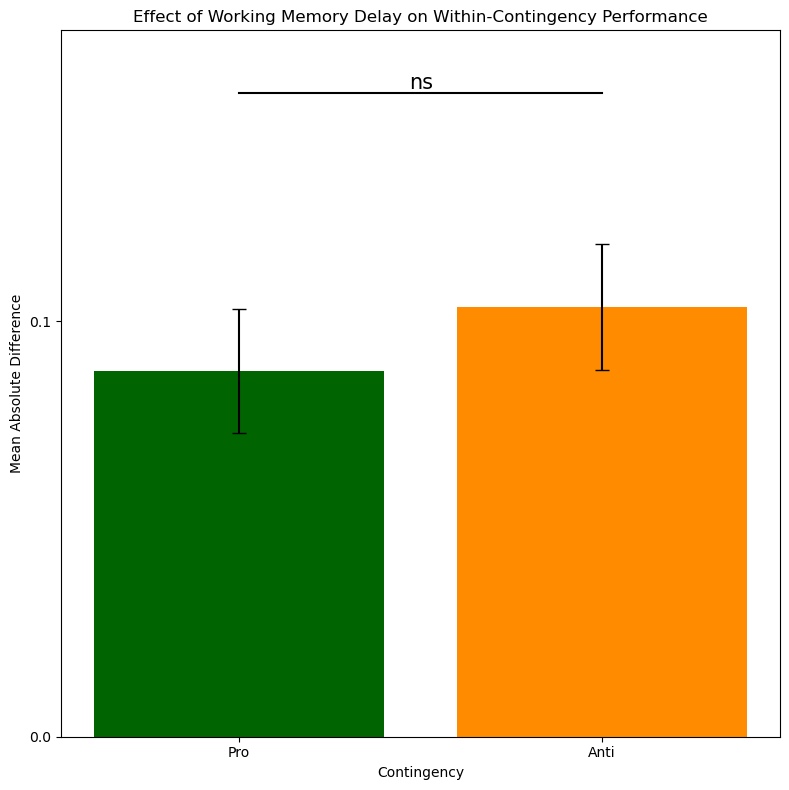

In [ ]:
# Separating Pro and Anti data
diff_pro = diff_results_df['Diff_Pro']
diff_anti = diff_results_df['Diff_Anti']

# Plotting with SEM
fig, ax = plt.subplots(figsize=(8, 8))

# Bar heights
mean_diff_pro = diff_pro.mean()
mean_diff_anti = diff_anti.mean()

# Calculate SEM (Standard Error of the Mean)
error_pro = diff_pro.sem()
error_anti = diff_anti.sem()

# Bar plot
ax.bar('Diff Pro', mean_diff_pro, yerr=error_pro, capsize=5, color=color_dict['Pro'])
ax.bar('Diff Anti', mean_diff_anti, yerr=error_anti, capsize=5, color=color_dict['Anti'])
ax.set_yticks([0, 0.1])
ax.set_ylim(0, 0.17)

# Labeling
ax.set_xlabel('Contingency')
ax.set_xticks([0, 1], ['Pro', 'Anti'])
ax.set_ylabel('Mean Absolute Difference')
ax.set_title('Effect of Working Memory Delay on Within-Contingency Performance')

x_values = [0, 1]
y_values = [0.155, 0.155]
plt.plot(x_values, y_values, color='black')
plt.text(0.5, y_values[0], "ns", ha='center', va='bottom', color='black', fontsize=15)

plt.tight_layout()
plt.savefig(figs_path + 'WMD_Difference_of_Differences.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Break execution at this cell
raise Exception('Stop here')

Exception: Stop here

In [ ]:
df.Participant_ID.unique()

['QP084', 'QP085', 'QP0108']
Categories (4, object): ['QP083' < 'QP084' < 'QP085' < 'QP0108']

In [ ]:
subj = 'QP0108'
p_id = 'QP0108'

start_date = '2023/11/09'
end_date = '2023/12/22'

sub_df = df[(df['Participant_ID'] == subj) & (df['Date'] >= start_date) & (df['Date'] <= end_date)]

sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
sub_df['Working_Memory_Delay'] = sub_df['Working_Memory_Delay'].fillna('00:00:00.5000000')
sub_df = sub_df[sub_df['Air_Puff_Contingency'].notna()].reset_index(drop=True)

In [ ]:
p_ids = ['QP083', 'QP084', 'QP085']
date_lim = '2024/01/17'
sub_df = df[(df['Date'] >= date_lim) & (df['Participant_ID'].isin(p_ids))].reset_index(drop=True)
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
sub_df['Working_Memory_Delay'] = sub_df['Working_Memory_Delay'].fillna('00:00:00.5000000')
sub_df = sub_df[sub_df['Air_Puff_Contingency'].notna()].reset_index(drop=True)

In [ ]:
p_id = ' '

QP0108_data = df[(df['Participant_ID'] == 'QP0108') & (df['Date'] >= '2023/11/09') & (df['Date'] <= '2023/12/22')].reset_index(drop=True)

QP083_4_5_data = df[(df['Date'] >= '2024/01/17') & (df['Participant_ID'].isin(['QP083', 'QP084', 'QP085']))].reset_index(drop=True)

# concatenate the two dataframes
sub_df = pd.concat([QP0108_data, QP083_4_5_data], axis=0).reset_index(drop=True)
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
sub_df['Working_Memory_Delay'] = sub_df['Working_Memory_Delay'].fillna('00:00:00.5000000')
sub_df = sub_df[sub_df['Air_Puff_Contingency'].notna()].reset_index(drop=True)

In [ ]:
# only include data fpr QP083
p_id = 'QP085'
date_lim = '2024/01/17'
sub_df = df[(df['Date'] >= date_lim) & (df.Participant_ID == p_id)].reset_index(drop=True)
sub_df = sub_df[sub_df['No_response'] == False].reset_index(drop=True)
sub_df['Working_Memory_Delay'] = sub_df['Working_Memory_Delay'].fillna('00:00:00.5000000')
sub_df = sub_df[sub_df['Air_Puff_Contingency'].notna()].reset_index(drop=True)


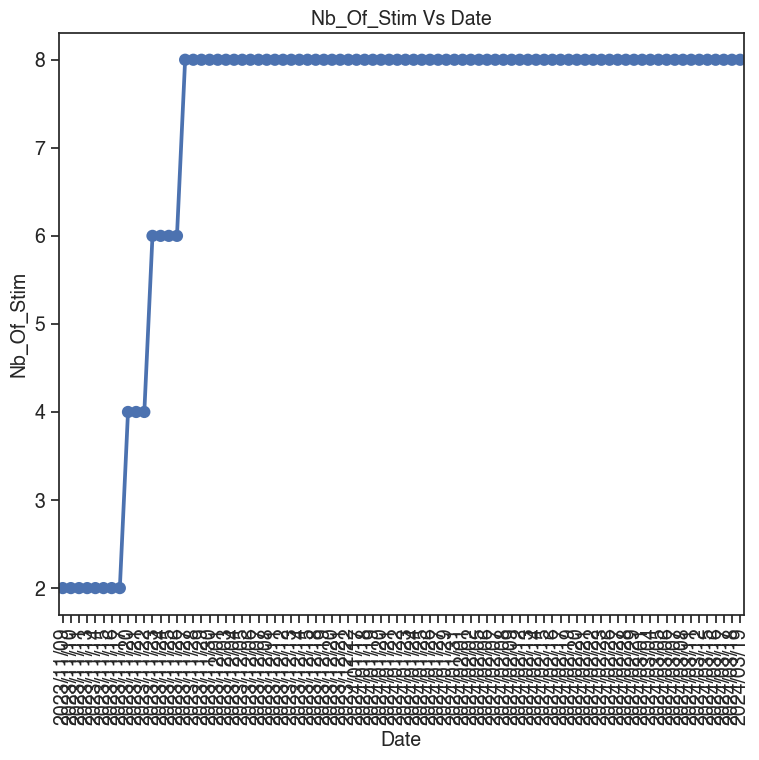

In [ ]:
# plot the Nb_Of_Stim Vs Date for sub_df
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

sns.pointplot(x='Date', y='Nb_Of_Stim', data=sub_df, ax=ax, ci=None, color='b', label='Nb_Of_Stim')
ax.set_ylabel('Nb_Of_Stim')
ax.set_xlabel('Date')
ax.set_title('Nb_Of_Stim Vs Date')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
desired_order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01', '00:00:01.2500000']
sub_df.Working_Memory_Delay = pd.Categorical(sub_df.Working_Memory_Delay, categories=desired_order, ordered=True)

# Define the conditions
conditions = [
    (sub_df['Air_Puff_Contingency'] == 'Pro') & (sub_df['Air_Puff_Side'] == 'Right'),
    (sub_df['Air_Puff_Contingency'] == 'Pro') & (sub_df['Air_Puff_Side'] == 'Left'),
    (sub_df['Air_Puff_Contingency'] == 'Anti') & (sub_df['Air_Puff_Side'] == 'Right'),
    (sub_df['Air_Puff_Contingency'] == 'Anti') & (sub_df['Air_Puff_Side'] == 'Left')
]

# Define the choices for each condition
choices = [
          sub_df['choice'],           # Pro and Right
          1 - sub_df['choice'],       # Pro and Left
          sub_df['choice'],           # Anti and Right
          1 - sub_df['choice']        # Anti and Left
]

# Create the new column
sub_df['Pro_Choice'] = np.select(conditions, choices, default=np.nan)

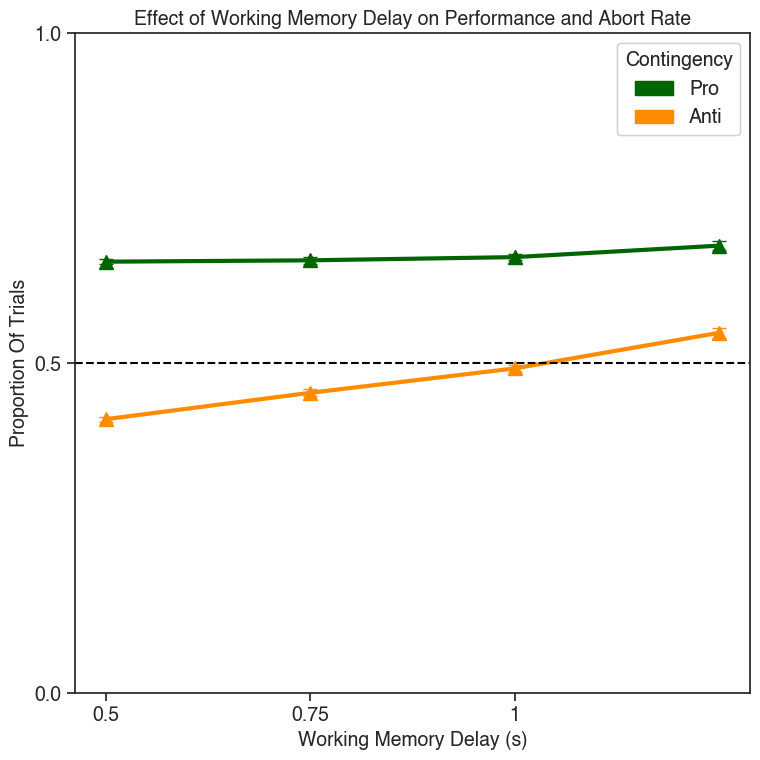

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

marker_dict = { 
    'Pro_Rate': '^',
    'Abort_Rate': 'o',
}

color_dict = {
    'Pro': 'darkgreen',
    'Anti': 'darkorange'
}

for i, contingency in enumerate(sub_df.Air_Puff_Contingency.unique()):
    contingency_df = sub_df[sub_df['Air_Puff_Contingency'] == contingency]
    label = f'{contingency}'

    # Calculate CI
    sem_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].sem()

    # Manually plot data with triangles as markers
    x_values = np.arange(len(desired_order))  # Shift x-values to separate Pro and Anti
    y_values = contingency_df.groupby('Working_Memory_Delay')['Pro_Choice'].mean()
    
    plt.plot(x_values, y_values, marker=marker_dict['Pro_Rate'], linestyle='-', 
             color=color_dict[contingency], label=label, markersize=10,
                linewidth=3)

    # Manually adding error bars
    for j, delay in enumerate(desired_order):
        y_value = y_values[desired_order[j]]
        sem_value = sem_values[desired_order[j]]

        plt.errorbar(x_values[j], y_value, yerr=[[sem_value], [sem_value]], fmt='none', 
                     ecolor=color_dict[contingency],
                     capsize=5)
        
        
plt.ylim(0, 1)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.ylabel('Proportion Of Trials')

plt.xlabel('Working Memory Delay (s)')
plt.xticks([0, 1, 2], ['0.5', '0.75', '1'])
plt.yticks (np.arange(0, 1.1, 0.5))
contingency_legend_labels = ['Pro', 'Anti']
contingency_legend_colors = [color_dict[label] for label in contingency_legend_labels]
contingency_legend = [mpatches.Patch(color=color, label=label) for label, color in zip(contingency_legend_labels, contingency_legend_colors)]


# Create two separate legend instances
legend1 = plt.legend(handles=contingency_legend, title="Contingency", loc = 'upper right')

# Add the legend instances to the plot
plt.gca().add_artist(legend1)
plt.title('Effect of Working Memory Delay on Performance and Abort Rate')
plt.tight_layout()
# plt.savefig(figs_path + 'Effect_of_WMD_on_Perf_and_Abort.pdf', dpi=300, bbox_inches='tight')
plt.show()


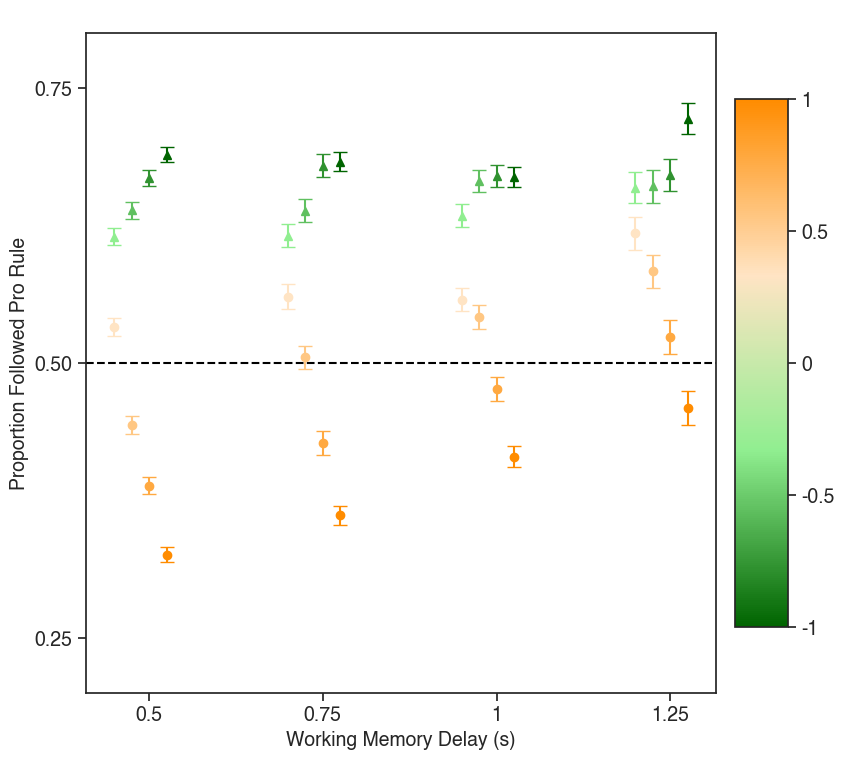

In [ ]:
# Calculate the absolute value of the 'stim_relative_binned' column and sort the unique values
sub_df['abs_stim_relative_binned'] = sub_df['stim_relative_binned'].abs()
sorted_abs_stim_values = sorted(sub_df['abs_stim_relative_binned'].unique())

# Create custom color gradients for 'Pro' and 'Anti' contingencies
pro_color_gradient = [mcolors.LinearSegmentedColormap.from_list("", ["lightgreen", "darkgreen"])(i) 
                      for i in np.linspace(0, 1, len(sorted_abs_stim_values))]
anti_color_gradient = [mcolors.LinearSegmentedColormap.from_list("", ["bisque", "darkorange"])(i) 
                       for i in np.linspace(0, 1, len(sorted_abs_stim_values))]

fig, ax = plt.subplots(1, 1, figsize=(9, 8))

# Plotting
for i, (contingency, color_gradient) in enumerate(zip(['Pro', 'Anti'], [pro_color_gradient, anti_color_gradient])):
    for j, stim_value in enumerate(sorted_abs_stim_values):
        subset_df = sub_df[(sub_df['Air_Puff_Contingency'] == contingency) &
                           (sub_df['abs_stim_relative_binned'] == stim_value)]

        # Calculate CI for each stim_value within the contingency
        sem_values = subset_df.groupby('Working_Memory_Delay')['Pro_Choice'].sem()
        y_values = subset_df.groupby('Working_Memory_Delay')['Pro_Choice'].mean()

        # Determine x_values with a shift to avoid overlapping
        x_values = np.arange(len(desired_order))  # No shift needed since colors are used to distinguish

        # Determine x_values with a shift to avoid overlapping
        x_values_shifted = np.arange(len(desired_order)) + (0.1 * (sorted_abs_stim_values.index(stim_value) - len(sorted_abs_stim_values)/2))

        # Plotting mean values with error bars
        ax.errorbar(x_values_shifted, y_values, yerr=sem_values, fmt='^' if contingency == 'Pro' else 'o', color=color_gradient[j],
                    label=f'{contingency} - {stim_value}', capsize=5)

plt.ylim(0.2, 0.8)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.ylabel('Proportion Followed Pro Rule')

plt.xlabel('Working Memory Delay (s)')
plt.xticks([0, 1, 2, 3], ['0.5', '0.75', '1', '1.25'])
# plt.yticks (np.arange(0, 1.1, 0.5))
plt.yticks([0.25, 0.5, 0.75])
# plt.yticklabels(['0', '0.25', '0.5', '0.75', '1'])
# plt.yticks['0', '0.25', '0.5', '0.75', '1'])

# Create a colorbar legend from a custom cmap, ensure that both extremes end with the darkest colors
cmap = mcolors.LinearSegmentedColormap.from_list("CustomCmap", ["darkgreen", "lightgreen", "bisque", "darkorange"])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=[0, 0.25, 0.5, 0.75, 1],
                    orientation='vertical', pad=0.025, aspect=10, shrink=0.8)
cbar.ax.set_yticklabels(['-1', '-0.5', '0', '0.5', '1'])
# cbar.set_label('Difficulty Gradient', rotation=270, labelpad=20)  # Set colorbar title
# cbar.ax.set_title('Distance from \n  boundary', loc='left', y = 1.05, x = -0.75)

plt.title(p_id)
 


# To ensure the colorbar is not too tight against the plot, adjust the right space
plt.subplots_adjust(right=0.85)
plt.tight_layout()
plt.savefig(figs_path + p_id + '_Effect_of_WMD_on_Perf_Full_Dist.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(figs_path + 'Effect_of_WMD_on_Perf_Full_Dist.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
2/3

0.6666666666666666

In [ ]:
1-0.66

0.33999999999999997

In [ ]:
# average data
x_range = np.linspace(-1, 1, 50)
kde_pro_total = compute_kde(x_range, sub_df.Stim_Relative.values, sub_df.Pro_Choice.values)
df_05s = sub_df[sub_df['Working_Memory_Delay'] == '00:00:00.5000000'].reset_index(drop=True)
df_075s = sub_df[sub_df['Working_Memory_Delay'] == '00:00:00.7500000'].reset_index(drop=True)
df_1s = sub_df[sub_df['Working_Memory_Delay'] == '00:00:01'].reset_index(drop=True)
df_125s = sub_df[sub_df['Working_Memory_Delay'] == '00:00:01.2500000'].reset_index(drop=True)

kde_pro_05s = compute_kde(x_range, df_05s.Stim_Relative.values, df_05s.Pro_Choice.values)
kde_pro_075s = compute_kde(x_range, df_075s.Stim_Relative.values, df_075s.Pro_Choice.values)
kde_pro_1s = compute_kde(x_range, df_1s.Stim_Relative.values, df_1s.Pro_Choice.values)
kde_pro_125s = compute_kde(x_range, df_125s.Stim_Relative.values, df_125s.Pro_Choice.values)

num_iterations = 100
boots_per_iter = 10
n = len(x_range)

kde_pro_total_boot_tensor = np.zeros((num_iterations, boots_per_iter, n))
for i in range(num_iterations):
    if i % 10 == 0:
        print(f'Iteration {i}')
    kde_pro_total_boot_tensor[i] = compute_bootstrap_kdes(x_range = x_range,
                                                    s = sub_df.Stim_Relative.values,
                                                    c = sub_df.Pro_Choice.values,
                                                    sigma=0.1,
                                                    n_bootstraps = boots_per_iter)
    

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90


In [ ]:
def filter_df_by_delay(df, delay):
    return df[df['Working_Memory_Delay'] == delay].reset_index(drop=True)

# Initialize dictionaries to hold the results
kde_results = {}
bootstrap_results = {}

# Define the delays
delays = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01', '00:00:01.2500000']

for delay in delays:
    # Filter the DataFrame for each delay
    df_filtered = filter_df_by_delay(sub_df, delay)
    
    # Compute the KDE for each delay
    kde_results[delay] = compute_kde(x_range, df_filtered.Stim_Relative.values, df_filtered.Pro_Choice.values)

    # Initialize the bootstrapping tensor
    bootstrap_tensor = np.zeros((num_iterations, boots_per_iter, n))

    # Perform bootstrapping
    for i in range(num_iterations):
        if i % 10 == 0:
            print(f'Iteration {i} for delay {delay}')

        for j in range(boots_per_iter):
            # Bootstrap sampling
            sample_indices = np.random.choice(len(df_filtered), size=len(df_filtered), replace=True)
            sample_stim = df_filtered.Stim_Relative.values[sample_indices]
            sample_choice = df_filtered.Pro_Choice.values[sample_indices]

            # Here you would compute the KDE for the bootstrap sample
            bootstrap_tensor[i, j] = compute_kde(x_range, sample_stim, sample_choice)

    # Store the results
    bootstrap_results[delay] = bootstrap_tensor


Iteration 0 for delay 00:00:00.5000000
Iteration 10 for delay 00:00:00.5000000
Iteration 20 for delay 00:00:00.5000000
Iteration 30 for delay 00:00:00.5000000
Iteration 40 for delay 00:00:00.5000000
Iteration 50 for delay 00:00:00.5000000
Iteration 60 for delay 00:00:00.5000000
Iteration 70 for delay 00:00:00.5000000
Iteration 80 for delay 00:00:00.5000000
Iteration 90 for delay 00:00:00.5000000
Iteration 0 for delay 00:00:00.7500000
Iteration 10 for delay 00:00:00.7500000
Iteration 20 for delay 00:00:00.7500000
Iteration 30 for delay 00:00:00.7500000
Iteration 40 for delay 00:00:00.7500000
Iteration 50 for delay 00:00:00.7500000
Iteration 60 for delay 00:00:00.7500000
Iteration 70 for delay 00:00:00.7500000
Iteration 80 for delay 00:00:00.7500000
Iteration 90 for delay 00:00:00.7500000
Iteration 0 for delay 00:00:01
Iteration 10 for delay 00:00:01
Iteration 20 for delay 00:00:01
Iteration 30 for delay 00:00:01
Iteration 40 for delay 00:00:01
Iteration 50 for delay 00:00:01
Iteration 6

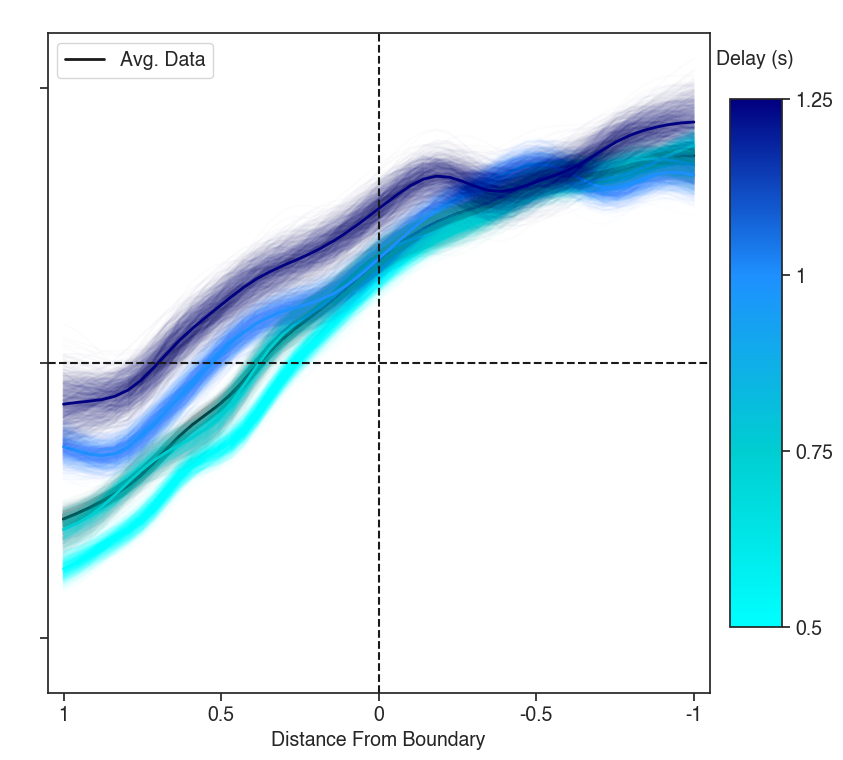

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 8))

color_dict = {
    '00:00:00.5000000': 'cyan',
    '00:00:00.7500000': 'darkturquoise',
    '00:00:01': 'dodgerblue',
    '00:00:01.2500000': 'navy'
    }

for i in range(num_iterations):
    for j in range(boots_per_iter):
        ax.plot(x_range * -1, kde_pro_total_boot_tensor[i][j], color='darkgray', alpha=0.01)
ax.plot(x_range * -1, np.mean(kde_pro_total_boot_tensor, axis=(0,1)), color='k', linestyle='-', linewidth=2, label='Avg. Data')

for delay in delays:
    kde_boot = bootstrap_results[delay]
    for i in range(num_iterations):
        for j in range(boots_per_iter):
            ax.plot(x_range * -1, kde_boot[i][j], color=color_dict[delay], alpha=0.01)
    ax.plot(x_range * -1, np.mean(kde_boot, axis=(0,1)), color=color_dict[delay], linestyle='-', linewidth=2)


# Define the Cyan to Navy color map
colors_hex = ['cyan', 'darkturquoise', 'dodgerblue', 'navy']
cmap = LinearSegmentedColormap.from_list("cyan_to_navy", colors_hex)


# set x and y ticks, labels and limits
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticklabels(['1', '0.5', '0', '-0.5', '-1'])  # because we multiply the x_range by -1
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
# ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
# set y ticklabels to blanks
ax.set_yticklabels([])
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(0.2, 0.8)
ax.set_xlabel('Distance From Boundary')
ax.set_ylabel(' ') 
ax.set_title(p_id)
# vertical line at 0 and dotted horizontal line at 0.5
ax.axvline(x=0, color='k', linestyle='--')
ax.axhline(y=0.5, color='k', linestyle='--')

# Create a ScalarMappable and initialize with the colormap
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(delays) - 1))

# Add a color bar to the figure
cbar = plt.colorbar(sm, ax=ax, ticks=np.arange(len(delays)), orientation='vertical', 
                    pad=0.025, aspect=10, 
                    shrink=0.8)
cbar.set_ticklabels(['0.5', '0.75', '1', '1.25'])
# cbar.set_label('Delay Duration (s)', rotation=270, labelpad=20)  # Set colorbar title
cbar.ax.set_title('Delay (s)', loc='left', y = 1.05, x = -0.25)
ax.legend()

plt.tight_layout()
# save figure as pdf in the figures folder
plt.savefig(figs_path + p_id + '_Follow_Pro_KDEs_By_Delay.pdf', dpi=300, bbox_inches='tight')
# plt.savefig(figs_path + 'Follow_Pro_KDEs_By_Delay.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# break execution at this cell
raise Exception('Stop here')

Exception: Stop here

In [ ]:
all_data.Air_Puff_Contingency_Rule.unique()

array([nan, 'Blocks_15', 'Random_Alternation'], dtype=object)

In [ ]:
# I have a dataframe with a sub_df.columns, and I want to know the numbers of rows for each unique value in the 'Working_Memory_Delay' column
sub_df.Working_Memory_Delay.value_counts()

00:00:00.5000000    22442
00:00:00.7500000    12810
00:00:01            12680
00:00:01.2500000     2874
Name: Working_Memory_Delay, dtype: int64

## Compare different distributions 

In [23]:
participant_id = 'QP083'
# p_ids = ['QP083', 'QP084', 'QP085']
# date_cutoff = '2024/03/16'
date_cutoff = '2024/03/02'

participant_df = df[df['Participant_ID'] == participant_id]
# participant_df = df[(df['Date'] >= date_cutoff) & (df['Participant_ID'].isin(p_ids))].reset_index(drop=True)
participant_df = participant_df[participant_df['Date'] >= date_cutoff]
participant_df = participant_df[participant_df['No_response'] == False]

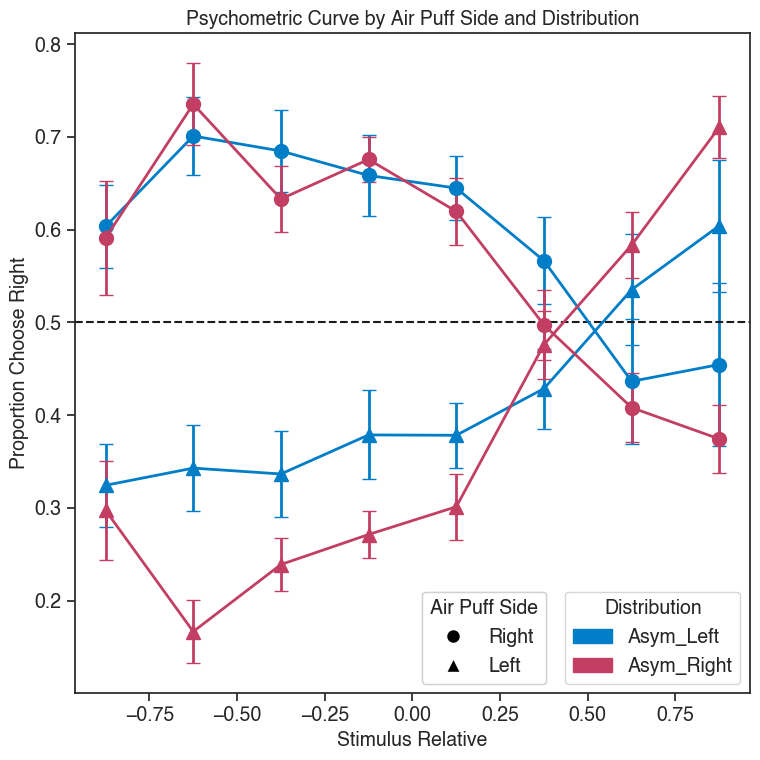

In [22]:
# Define your marker and color dictionaries
marker_dict = {'Right': 'o', 'Left': '^'}
color_dict = {
    # 'Uniform': '#2F9A76', 
              'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}

# Group by 'stim_relative_binned', 'Air_Puff_Side', and 'Distribution', then calculate mean and SEM
grouped_data = participant_df.groupby(['stim_relative_binned', 'Air_Puff_Side', 'Distribution'])
mean_choices = grouped_data['choice'].mean().reset_index(name='mean_choice')
sem_choices = grouped_data['choice'].sem().reset_index(name='sem_choice')

# Merge the mean and SEM dataframes
plot_data = pd.merge(mean_choices, sem_choices, on=['stim_relative_binned', 'Air_Puff_Side', 'Distribution'])

# Preparing the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plotting for each 'Air_Puff_Side' and 'Distribution'
for distribution in color_dict:
    for air_puff_side in marker_dict:
        data_to_plot = plot_data[(plot_data['Air_Puff_Side'] == air_puff_side) &
                                 (plot_data['Distribution'] == distribution)]
        
        ax.errorbar(data_to_plot['stim_relative_binned'], data_to_plot['mean_choice'],
                     yerr=data_to_plot['sem_choice'], fmt=marker_dict[air_puff_side], 
                     color=color_dict[distribution], label=f'{air_puff_side}, {distribution}',
                     capsize=5, linestyle='-', # increase marker sise
                        markersize=10, linewidth=2)

# Enhancing the plot
ax.axhline(y=0.5, color='k', linestyle='--')
ax.set_title('Psychometric Curve by Air Puff Side and Distribution')
ax.set_xlabel('Stimulus Relative')
ax.set_ylabel('Proportion Choose Right')
# set the ylim
# ax.set_ylim(0, 1)

# Create legend for Distribution
distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='lower right')

# Create custom legend for Air Puff Side
opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) 
                            for condition, marker in marker_dict.items() if marker]  # Exclude No_Stim if no marker needed
legend2 = ax.legend(handles=opto_condition_markers, title="Air Puff Side", loc='lower left', bbox_to_anchor=(0.5, 0))

# Add both legends to the plot
plt.gca().add_artist(legend1)  
plt.gca().add_artist(legend2)

plt.tight_layout()
# save as pdf in the figures folder
plt.savefig(figs_path + participant_id + '_Psycho_By_Air_Puff_And_Dist.pdf', dpi=300, bbox_inches='tight')
# Showing the plot
plt.show()


In [ ]:
# break execution at this cell
raise Exception('Stop here')

Exception: Stop here

In [52]:
sub_df = participant_df

In [53]:
# Define the conditions
conditions = [
    (sub_df['Air_Puff_Contingency'] == 'Pro') & (sub_df['Air_Puff_Side'] == 'Right'),
    (sub_df['Air_Puff_Contingency'] == 'Pro') & (sub_df['Air_Puff_Side'] == 'Left'),
    (sub_df['Air_Puff_Contingency'] == 'Anti') & (sub_df['Air_Puff_Side'] == 'Right'),
    (sub_df['Air_Puff_Contingency'] == 'Anti') & (sub_df['Air_Puff_Side'] == 'Left')
]

# Define the choices for each condition
choices = [
          sub_df['choice'],           # Pro and Right
          1 - sub_df['choice'],       # Pro and Left
          sub_df['choice'],           # Anti and Right
          1 - sub_df['choice']        # Anti and Left
]

# Create the new column
sub_df['Pro_Choice'] = np.select(conditions, choices, default=np.nan)

In [54]:
# average data
x_range = np.linspace(-1, 1, 50)
# kde_pro_total = compute_kde(x_range, sub_df.Stim_Relative.values, sub_df.Pro_Choice.values)
df_asym_l = sub_df[sub_df['Distribution'] == 'Asym_Left'].reset_index(drop=True)
df_asym_r = sub_df[sub_df['Distribution'] == 'Asym_Right'].reset_index(drop=True)
df_asum_u = sub_df[sub_df['Distribution'] == 'Uniform'].reset_index(drop=True)


kde_asym_l = compute_kde(x_range, df_asym_l.Stim_Relative.values, df_asym_l.Pro_Choice.values)
kde_asym_r = compute_kde(x_range, df_asym_r.Stim_Relative.values, df_asym_r.Pro_Choice.values)
kde_asum_u = compute_kde(x_range, df_asum_u.Stim_Relative.values, df_asum_u.Pro_Choice.values)

In [55]:
num_iterations = 100
boots_per_iter = 10
n = len(x_range)

# Initialize dictionaries to hold the results
kde_results = {}
bootstrap_results = {}

# distributions = sub_df.Distribution.unique()
distributions = ['Asym_Left', 'Asym_Right', 
                 'Uniform'
                 ]

for distribution in distributions:
    # Filter the DataFrame for each distribution
    df_dist = sub_df[sub_df['Distribution'] == distribution].reset_index(drop=True)
    
    # Compute the KDE for each distribution
    kde_results[distribution] = compute_kde(x_range, df_dist.Stim_Relative.values, df_dist.Pro_Choice.values)

    # Initialize the bootstrapping tensor
    bootstrap_tensor = np.zeros((num_iterations, boots_per_iter, n))

    # Perform bootstrapping
    for i in range(num_iterations):
        if i % 10 == 0:
            print(f'Iteration {i} for distribution {distribution}')

        for j in range(boots_per_iter):
            # Bootstrap sampling
            sample_indices = np.random.choice(len(df_dist), size=len(df_dist), replace=True)
            sample_stim = df_dist.Stim_Relative.values[sample_indices]
            sample_choice = df_dist.Pro_Choice.values[sample_indices]

            # Here you would compute the KDE for the bootstrap sample
            bootstrap_tensor[i, j] = compute_kde(x_range, sample_stim, sample_choice)

    # Store the results
    bootstrap_results[distribution] = bootstrap_tensor

Iteration 0 for distribution Asym_Left
Iteration 10 for distribution Asym_Left
Iteration 20 for distribution Asym_Left
Iteration 30 for distribution Asym_Left
Iteration 40 for distribution Asym_Left
Iteration 50 for distribution Asym_Left
Iteration 60 for distribution Asym_Left
Iteration 70 for distribution Asym_Left
Iteration 80 for distribution Asym_Left
Iteration 90 for distribution Asym_Left
Iteration 0 for distribution Asym_Right
Iteration 10 for distribution Asym_Right
Iteration 20 for distribution Asym_Right
Iteration 30 for distribution Asym_Right
Iteration 40 for distribution Asym_Right
Iteration 50 for distribution Asym_Right
Iteration 60 for distribution Asym_Right
Iteration 70 for distribution Asym_Right
Iteration 80 for distribution Asym_Right
Iteration 90 for distribution Asym_Right
Iteration 0 for distribution Uniform
Iteration 10 for distribution Uniform
Iteration 20 for distribution Uniform
Iteration 30 for distribution Uniform
Iteration 40 for distribution Uniform
Ite

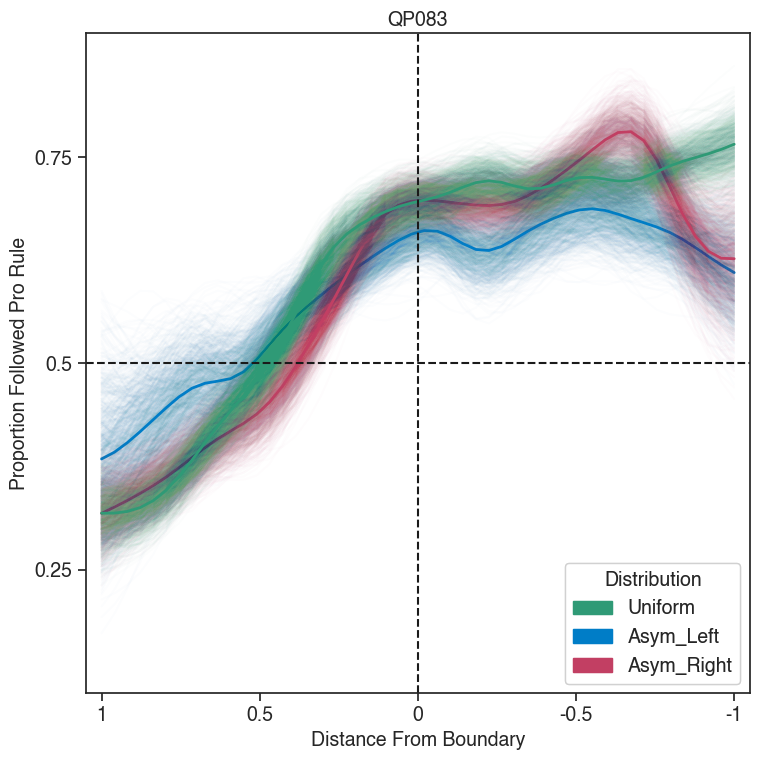

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

color_dict = {
    'Uniform': '#2F9A76', 
              'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}

# for i in range(num_iterations):
#     for j in range(boots_per_iter):
#         ax.plot(x_range * -1, kde_pro_total_boot_tensor[i][j], color='darkgray', alpha=0.01)
# ax.plot(x_range * -1, np.mean(kde_pro_total_boot_tensor, axis=(0,1)), color='k', linestyle='-', linewidth=2, label='Avg. Data')

# for delay in delays:
#     kde_boot = bootstrap_results[delay]
#     for i in range(num_iterations):
#         for j in range(boots_per_iter):
#             ax.plot(x_range * -1, kde_boot[i][j], color=color_dict[delay], alpha=0.01)
#     ax.plot(x_range * -1, np.mean(kde_boot, axis=(0,1)), color=color_dict[delay], linestyle='-', linewidth=2)

for dist in distributions:
    kde_boot = bootstrap_results[dist]
    for i in range(num_iterations):
        for j in range(boots_per_iter):
            ax.plot(x_range * -1, kde_boot[i][j], color=color_dict[dist], alpha=0.01)
    ax.plot(x_range * -1, np.mean(kde_boot, axis=(0,1)), color=color_dict[dist], linestyle='-', linewidth=2)


# # Define the Cyan to Navy color map
# colors_hex = ['cyan', 'darkturquoise', 'dodgerblue', 'navy']
# cmap = LinearSegmentedColormap.from_list("cyan_to_navy", colors_hex)


# set x and y ticks, labels and limits
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticklabels(['1', '0.5', '0', '-0.5', '-1'])  # because we multiply the x_range by -1
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticklabels(['0', '0.25', '0.5', '0.75', '1'])
# set y ticklabels to blanks
# ax.set_yticklabels([])
ax.set_xlim(-1.05, 1.05)
ax.set_ylim(0.1, 0.9)
ax.set_xlabel('Distance From Boundary')
ax.set_ylabel('Proportion Followed Pro Rule')
ax.set_title(participant_id)
# vertical line at 0 and dotted horizontal line at 0.5
ax.axvline(x=0, color='k', linestyle='--')
ax.axhline(y=0.5, color='k', linestyle='--')

distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='lower right')

# Add both legends to the plot
plt.gca().add_artist(legend1)  

plt.tight_layout()
# save as pdf in the figures folder
plt.savefig(figs_path + participant_id + '_Follow_Pro_KDEs_By_Distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

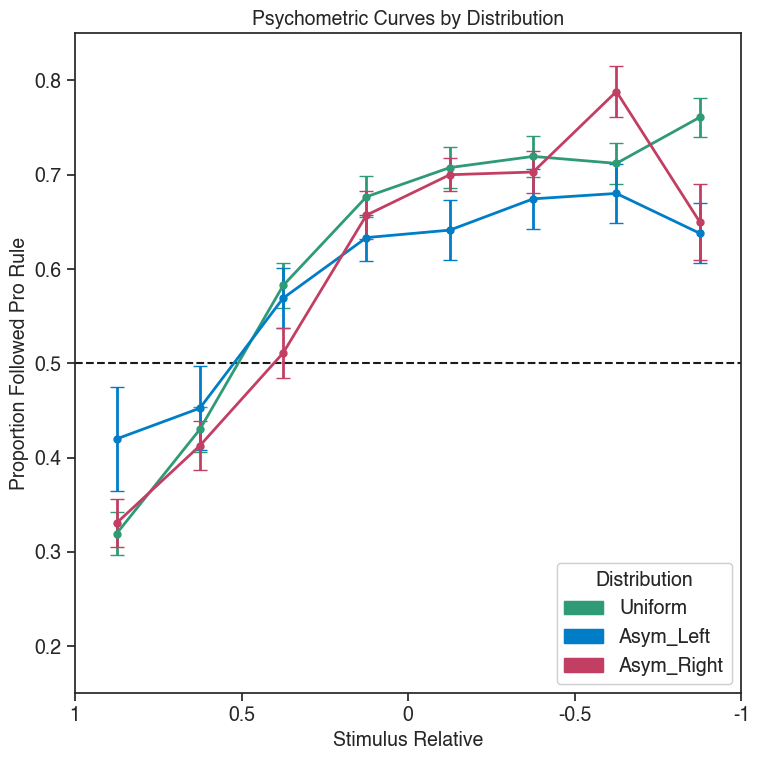

In [72]:
# Define your marker and color dictionaries
# marker_dict = {'Right': 'o', 'Left': '^'}
color_dict = {
    'Uniform': '#2F9A76', 
              'Asym_Left': '#007dc7', 'Asym_Right': '#c23f63'}

# Group by 'stim_relative_binned', 'Air_Puff_Side', and 'Distribution', then calculate mean and SEM
grouped_data = participant_df.groupby(['stim_relative_binned', 'Distribution'])
mean_pro_choices = grouped_data['Pro_Choice'].mean().reset_index(name='mean_pro_choice')
sem_pro_choices = grouped_data['Pro_Choice'].sem().reset_index(name='sem_pro_choice')

# Merge the mean and SEM dataframes
plot_data = pd.merge(mean_pro_choices, sem_pro_choices, on=['stim_relative_binned', 'Distribution'])

# Preparing the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plotting for each 'Air_Puff_Side' and 'Distribution'
for distribution in color_dict:
    data_to_plot = plot_data[(plot_data['Distribution'] == distribution)]
    
    ax.errorbar(data_to_plot['stim_relative_binned']*-1, data_to_plot['mean_pro_choice'],
                    yerr=data_to_plot['sem_pro_choice'], marker = 'o',
                    color=color_dict[distribution], label=f'{distribution}',
                    capsize=5, linestyle='-', # increase marker sise
                    markersize=5, linewidth=2)

# Enhancing the plot
ax.axhline(y=0.5, color='k', linestyle='--')
ax.set_title('Psychometric Curves by Distribution')
ax.set_xlabel('Stimulus Relative')
ax.set_ylabel('Proportion Followed Pro Rule')
# set the ylim
ax.set_ylim(0.15, 0.85)
ax.set_xlim(-1, 1)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticklabels(['1', '0.5', '0', '-0.5', '-1']) 

# Create legend for Distribution
distribution_patches = [Patch(color=color, label=distribution) for distribution, color in color_dict.items()]
legend1 = ax.legend(handles=distribution_patches, title="Distribution", loc='lower right')

# # Create custom legend for Air Puff Side
# opto_condition_markers = [Line2D([0], [0], marker=marker, color='w', label=condition, markerfacecolor='black', markersize=10) 
#                             for condition, marker in marker_dict.items() if marker]  # Exclude No_Stim if no marker needed
# legend2 = ax.legend(handles=opto_condition_markers, title="Air Puff Side", loc='lower left', bbox_to_anchor=(0.5, 0))

# Add both legends to the plot
plt.gca().add_artist(legend1)  
# plt.gca().add_artist(legend2)

plt.tight_layout()
# save as pdf in the figures folder
plt.savefig(figs_path + participant_id + '_Psycho_By_Dist.pdf', dpi=300, bbox_inches='tight')
# Showing the plot
plt.show()

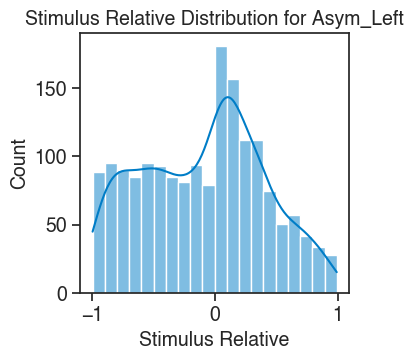

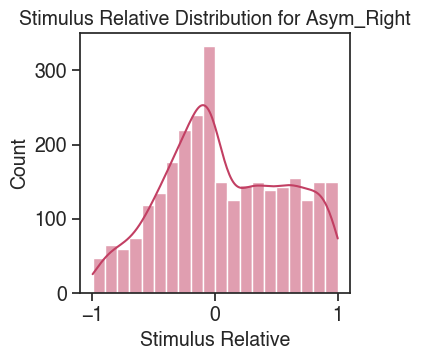

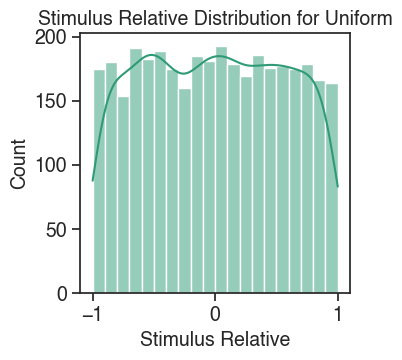

In [74]:
# plot histogram of stim_relative for each distribution

for dist in distributions:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    sns.histplot(data=sub_df[sub_df['Distribution'] == dist], x='Stim_Relative', kde=True, bins=20, color=color_dict[dist])
    ax.set_title(f'Stimulus Relative Distribution for {dist}')
    ax.set_xlabel('Stimulus Relative')
    ax.set_ylabel('Count')
    plt.tight_layout()
    # plt.savefig(figs_path + participant_id + f'_Stim_Relative_Histogram_{dist}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

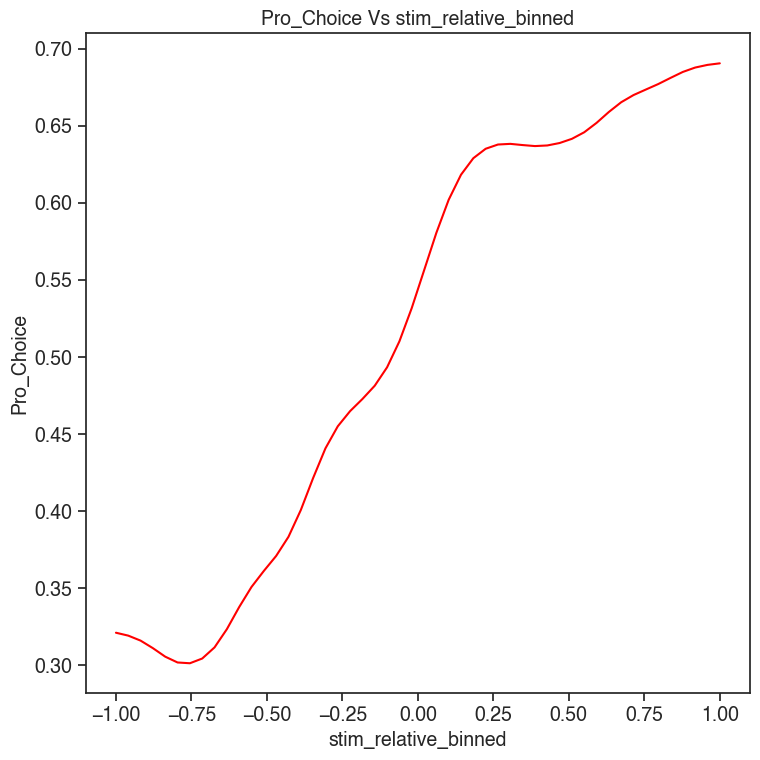

In [ ]:
# make plot of Pro_Choice Vs stim_relative_binned with seaborn

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# sns.pointplot(x='stim_relative_binned', y='Pro_Choice', data=sub_df, ax=ax, ci=None, color='b', label='Pro_Choice')
plt.plot(x_range * -1, kde_pro, label='KDE', color='red')

ax.set_ylabel('Pro_Choice')
ax.set_xlabel('stim_relative_binned')
ax.set_title('Pro_Choice Vs stim_relative_binned')
# plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
sub_df

,Participant_ID,Protocol,Stage,Trial,Correct_Count,Sound_Contingency,Stim_Relative,correct,No_response,Rule,...,Datetime,block,Incorrect,choice,Rule_Right,Choice_Rule_Diff,stim_relative_binned,Average_Contingency_Run_Length,Air_Puff_Contingency_Rule,Pro_Choice
0,QP0108,PRO_ANTI,Full_Task_Disc,1.0,0.0,Low_Left_High_Right,1.000000,0,False,NaN,...,2023-11-09,41,1,0,1,-1,0.875,1.940150,Random_Alternation,1.0
1,QP0108,PRO_ANTI,Full_Task_Disc,2.0,1.0,Low_Left_High_Right,-1.000000,1,False,NaN,...,2023-11-09,41,0,1,1,0,-0.875,1.940150,Random_Alternation,1.0
2,QP0108,PRO_ANTI,Full_Task_Disc,3.0,1.0,Low_Left_High_Right,1.000000,0,False,NaN,...,2023-11-09,41,1,0,1,-1,0.875,1.940150,Random_Alternation,1.0
3,QP0108,PRO_ANTI,Full_Task_Disc,4.0,1.0,Low_Left_High_Right,1.000000,0,False,NaN,...,2023-11-09,41,1,1,0,1,0.875,1.940150,Random_Alternation,1.0
4,QP0108,PRO_ANTI,Full_Task_Disc,5.0,2.0,Low_Left_High_Right,1.000000,1,False,NaN,...,2023-11-09,41,0,1,1,0,0.875,1.940150,Random_Alternation,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17673,QP0108,PRO_ANTI,Full_Task_Cont,569.0,365.0,Low_Left_High_Right,-0.001854,0,False,NaN,...,2023-12-22,76,1,1,0,1,-0.125,2.065672,Random_Alternation,0.0
17674,QP0108,PRO_ANTI,Full_Task_Cont,571.0,365.0,Low_Left_High_Right,0.759100,0,False,NaN,...,2023-12-22,76,1,1,0,1,0.875,2.065672,Random_Alternation,1.0
17675,QP0108,PRO_ANTI,Full_Task_Cont,576.0,366.0,Low_Left_High_Right,-0.068224,1,False,NaN,...,2023-12-22,76,0,0,0,0,-0.125,2.065672,Random_Alternation,1.0
17676,QP0108,PRO_ANTI,Full_Task_Cont,577.0,366.0,Low_Left_High_Right,-0.086244,0,False,NaN,...,2023-12-22,76,1,1,0,1,-0.125,2.065672,Random_Alternation,0.0


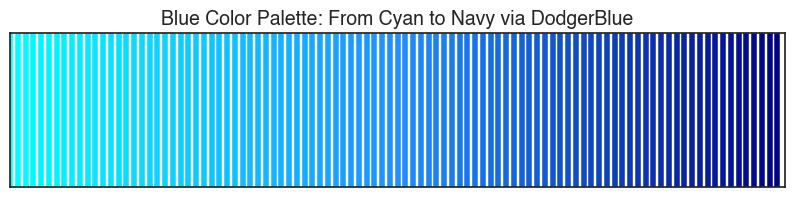

In [ ]:
import matplotlib.colors as mcolors

# Creating a blue color palette going from Cyan to Navy, passing through DodgerBlue

# Colors in hex
colors_hex = ['#00FFFF',  # Cyan
              '#1E90FF',  # DodgerBlue
              '#000080']  # Navy

# Convert hex to RGB for a smooth gradient
colors_rgb = [mcolors.to_rgb(color) for color in colors_hex]

# Function to interpolate between two colors
def interpolate_color(color1, color2, factor: float):
    """ Interpolate between two colors """
    return [color1[i] + factor * (color2[i] - color1[i]) for i in range(3)]

# Create a gradient palette
palette = []
n_steps = 50  # Number of steps between each main color
for i in range(len(colors_rgb) - 1):
    for step in range(n_steps):
        # Interpolate between color i and color i+1
        interpolated_color = interpolate_color(colors_rgb[i], colors_rgb[i+1], step / n_steps)
        palette.append(mcolors.to_hex(interpolated_color))

# Create a plot to display the palette
fig, ax = plt.subplots(figsize=(10, 2))

# Display each color in the palette
for i, color in enumerate(palette):
    ax.axvline(i, color=color, linewidth=4)

# Remove y-axis and ticks
ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.set_xlim(0, len(palette))

plt.title('Blue Color Palette: From Cyan to Navy via DodgerBlue')
plt.show()





In [ ]:
all_data.Animal_ID.unique()

array(['QP084'], dtype=object)

In [ ]:
# Performing a paired t-test
t_stat_paired, p_value_paired = stats.ttest_rel(diff_pro, diff_anti)
print(f'Paired t-test: t = {t_stat_paired}, p = {p_value_paired}')


Paired t-test: t = -0.4868313887594511, p = 0.643650094651435


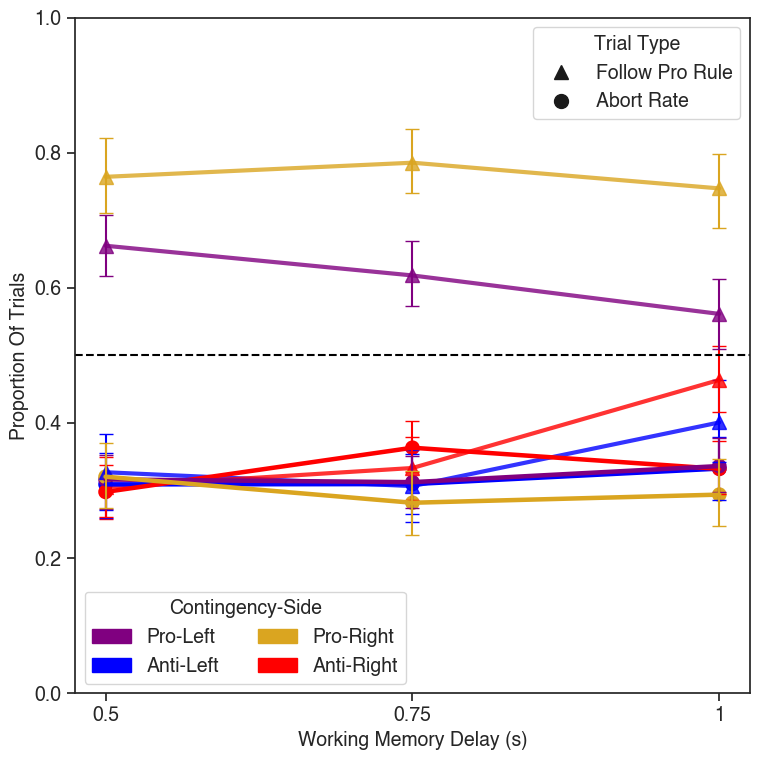

In [ ]:

# Expanded color dictionary
color_dict = {
    'Pro-Left': 'purple',
    'Anti-Left': 'blue',
    'Pro-Right': 'goldenrod',
    'Anti-Right': 'red'
}

# Assuming sub_df and df are already defined and contain the necessary data
# Rest of your existing setup...

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

marker_dict = { 
    'Pro_Rate': '^',
    'Abort_Rate': 'o',
}

desired_order = ['00:00:00.5000000', '00:00:00.7500000', '00:00:01']

# Plot for Pro_Rate
for contingency in sub_df.Air_Puff_Contingency.unique():
    for side in sub_df.Air_Puff_Side.unique():
        contingency_side_df = sub_df[(sub_df['Air_Puff_Contingency'] == contingency) & (sub_df['Air_Puff_Side'] == side)]
        label = f'{contingency}-{side}'
        ci_values = contingency_side_df.groupby('Working_Memory_Delay')['Pro_Choice'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))
        
        x_values = np.arange(len(desired_order)) # Adjust shift for different sides if needed
        y_values = contingency_side_df.groupby('Working_Memory_Delay')['Pro_Choice'].mean()
        
        plt.plot(x_values, y_values, marker=marker_dict['Pro_Rate'], linestyle='-', 
                 color=color_dict[label], label=label, markersize=10, linewidth=3, 
                 # increase transparency to show error bars
                    alpha=0.8)

        for j, delay in enumerate(desired_order):
            y_value = y_values[desired_order[j]]
            lower, upper = ci_values[delay]
            plt.errorbar(x_values[j], y_value, yerr=[[y_value - lower], [upper - y_value]], fmt='none', 
                         ecolor=color_dict[label], capsize=5)

# Repeat for Abort_Rate
sub_df_abort = df[(df['Participant_ID'] == subj) & (df['Date'].isin(dates))].reset_index(drop=True)
sub_df_abort['Abort_Trial'] = sub_df_abort['No_response'].astype(int)
sub_df_abort.Working_Memory_Delay = pd.Categorical(sub_df_abort.Working_Memory_Delay, categories=desired_order, ordered=True)

for contingency in sub_df_abort.Air_Puff_Contingency.unique():
    for side in sub_df_abort.Air_Puff_Side.unique():
        contingency_side_df = sub_df_abort[(sub_df_abort['Air_Puff_Contingency'] == contingency) & (sub_df_abort['Air_Puff_Side'] == side)]
        label = f'{contingency}-{side}'
        ci_values = contingency_side_df.groupby('Working_Memory_Delay')['Abort_Trial'].apply(lambda x: bootstrap_ci(x, n_bootstrap=1000, ci=95))
        
        # Plot data without CI
        sns.pointplot(x='Working_Memory_Delay', y='Abort_Trial', data=contingency_side_df, ax=ax, ci=None, 
                      color=color_dict[label], label=label, scale=1.2)
                        # increase transparency to show error bars


        for i, delay in enumerate(desired_order):
            y_value = contingency_side_df[contingency_side_df['Working_Memory_Delay'] == delay]['Abort_Trial'].mean()
            lower, upper = ci_values[delay]
            plt.errorbar(i, y_value, yerr=[[y_value - lower], [upper - y_value]], fmt='none', 
                         ecolor=color_dict[label], capsize=5)

plt.ylim(0, 1)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.ylabel('Proportion Of Trials')
plt.xlabel('Working Memory Delay (s)')
plt.xticks([0, 1, 2], ['0.5', '0.75', '1'])

# Update the legend
contingency_side_legend_labels = ['Pro-Left', 'Anti-Left', 'Pro-Right', 'Anti-Right']
contingency_side_legend_colors = [color_dict[label] for label in contingency_side_legend_labels]
contingency_side_legend = [mpatches.Patch(color=color, label=label) for label, color in zip(contingency_side_legend_labels, contingency_side_legend_colors)]

marker_legend_labels = ['Pro_Rate', 'Abort_Rate']
larker_actual_labels = ['Follow Pro Rule', 'Abort Rate']
marker_legend_handles = [mlines.Line2D([], [], color='k', marker=marker_dict[label], linestyle='',
                                      markersize=10, label=new_label) for label, new_label in zip(marker_legend_labels, larker_actual_labels)]

# legend1 = plt.legend(handles=contingency_side_legend, title="Contingency-Side", loc='upper right')
# legend2 = plt.legend(handles=marker_legend_handles, title="Trial Type", loc='upper left')
# Place the "Contingency-Side" legend at the bottom right in two columns
legend1 = plt.legend(handles=contingency_side_legend, title="Contingency-Side", loc='lower left', ncol=2)

# Place the "Trial Type" legend at the top right
legend2 = plt.legend(handles=marker_legend_handles, title="Trial Type", loc='upper right')

plt.gca().add_artist(legend1)
plt.tight_layout()
plt.show()


In [ ]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Exmplar mouse on blocks 30 and 15

In [ ]:
subj = 'QP0104'
date = '2023/10/23'

# only keep data for QP092, after 2023/10/23
participant_df = df[(df['Participant_ID'] == subj) & (df['Datetime'] == date)].reset_index(drop=True)
participant_df = participant_df[participant_df['No_response'] == False].reset_index(drop=True)

In [ ]:
jitter = 0.05
background_shading = True

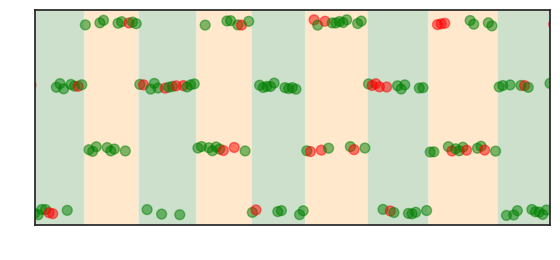

In [ ]:
for block in participant_df.block.unique():
    block_df = participant_df[participant_df['block'] == block].reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(6, 3))
    # y_labels = ['Pro Go L', 'Anti Go L', 'Pro Go R', 'Anti Go R']
    ax.set_yticks([])
    ax.set_xticks([])
    # ax.set_yticklabels(y_labels)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')

    # Background shading along x-axis
    if background_shading:
        start_index = 0
        current_type = block_df['Air_Puff_Contingency'].iloc[0]
        for i, row in block_df.iterrows():
            if row['Air_Puff_Contingency'] != current_type:
                color = 'darkgreen' if current_type == 'Pro' else 'darkorange'
                ax.axvspan(start_index - 0.5, i - 0.5, facecolor=color, alpha=0.2)
                start_index = i
                current_type = row['Air_Puff_Contingency']
        # Shade the final block
        color = 'darkgreen' if current_type == 'Pro' else 'darkorange'
        ax.axvspan(start_index - 0.5, i + 0.5, facecolor=color, alpha=0.2)


    # Mapping conditions to y-values using a dictionary
    y_map = {
        ('Pro', 0): 0,
        ('Anti', 0): 1,
        ('Pro', 1): 2,
        ('Anti', 1): 3
    }

    colors = ['green' if correct else 'red' for correct in block_df['correct']]
    y_values = block_df.apply(lambda row: y_map.get((row['Air_Puff_Contingency'], row['choice'])), axis=1)

    # Add jitter to y-values
    y_values += np.random.uniform(-jitter, jitter, len(y_values))

    # Plotting the points
    ax.scatter(block_df.index, y_values, color=colors, s=50, alpha=0.5)


    plt.xlim(116, 258)
    # plt.title(f'Participant {subj} on {block_df.Date[0]} (Block {block})')
    plt.tight_layout()
    # save in the figures folder
    plt.savefig(figs_path + f'{subj}_Examplar_Session.pdf', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

## QP069

In [ ]:
p_id, date = 'QP069', '2023_9_15'

In [ ]:
# read csv for QP069, 2023/09/15
df = pd.read_csv('/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/QP069/PRO_ANTI_QP069_2023_9_15/Trial_Summary2023-09-15T09_12_35.csv')

In [ ]:
# add 'Air_Puff_Side' column
df['Air_Puff_Side'] = np.nan
df['Air_Puff_Side'] = df.apply(pa_ut.compute_air_puff_side, axis=1)
df['choice'] = np.where(df['First_Lick']=='Right', 1, 0) # 


In [ ]:
# df = df[df.Abort_Trial == False].reset_index(drop=True)

In [ ]:
# Create a new column to specify y-values based on 'Air_Puff_Contingency' and 'First_Lick'
def assign_y(row):
    if row['Air_Puff_Contingency'] == 'Pro' and row['First_Lick'] == 'Left':
        return 1
    if row['Air_Puff_Contingency'] == 'Anti' and row['First_Lick'] == 'Left':
        return 2
    if row['Air_Puff_Contingency'] == 'Pro' and row['First_Lick'] == 'Right':
        return 3
    if row['Air_Puff_Contingency'] == 'Anti' and row['First_Lick'] == 'Right':
        return 4

In [ ]:
# Define the bins
bins_negative = [-1.0, -0.75, -0.5, -0.25, 0.0]
bins_positive = [0.0, 0.25, 0.5, 0.75, 1.0]

# Create masks for negative and positive values
mask_negative = df['Stim_Relative'] < 0
mask_positive = df['Stim_Relative'] > 0

# Bin the negative values with left inclusivity
binned_negative = pd.cut(df[mask_negative]['Stim_Relative'], bins=bins_negative, right=False, labels = np.arange(-0.875, 0, 0.25))

# Bin the positive values with right inclusivity
binned_positive = pd.cut(df[mask_positive]['Stim_Relative'], bins=bins_positive, right=True, labels = np.arange(0.125, 1, 0.25))

# Convert the binned categories to strings
binned_negative = binned_negative.astype(str)
binned_positive = binned_positive.astype(str)

# Assign binned values using masks
df.loc[mask_negative, 'stim_relative_binned'] = binned_negative
df.loc[mask_positive, 'stim_relative_binned'] = binned_positive
# df['stim_relative_binned'] = df['stim_relative_binned'].astype('category')
df['stim_relative_binned'] = pd.to_numeric(df['stim_relative_binned'], errors='coerce')

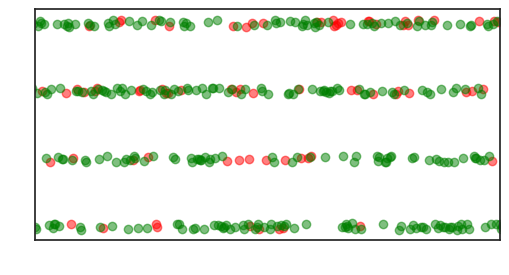

In [ ]:
jitter = 0.05
valid_df = df[df.Abort_Trial == False].reset_index(drop=True)
# Plotting
fig, ax = plt.subplots(figsize=(6, 3))

valid_df['y_values'] = valid_df.apply(assign_y, axis=1)
valid_df['y_values'] += np.random.uniform(-jitter, jitter, len(valid_df['y_values']))

colors = {True: 'green', False: 'red'}
labels = {True: 'Correct', False: 'Incorrect'}

# To ensure each label is in the legend only once
handled_labels = []

for correct, group in valid_df.groupby('Correct'):
    ax.scatter(group.index, group['y_values'], color=colors[correct], 
               label=labels[correct] if labels[correct] not in handled_labels else "",
               alpha=0.5)
    handled_labels.append(labels[correct])

# Adjusting the plot
ax.set_yticks([])
ax.set_xticks([])
# ax.set_yticklabels(['Pro Go L', 'Anti Go L', 'Pro Go R', 'Anti Go R'])
ax.set_xlabel(" ")
ax.set_ylabel(" ")
ax.set_xlim(50, 410)
# ax.set_title(p_id + ' - example session')
ax.legend().remove()
# save as ped in figs_path
fig.savefig(figs_path + p_id + '_Examplar_Session.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

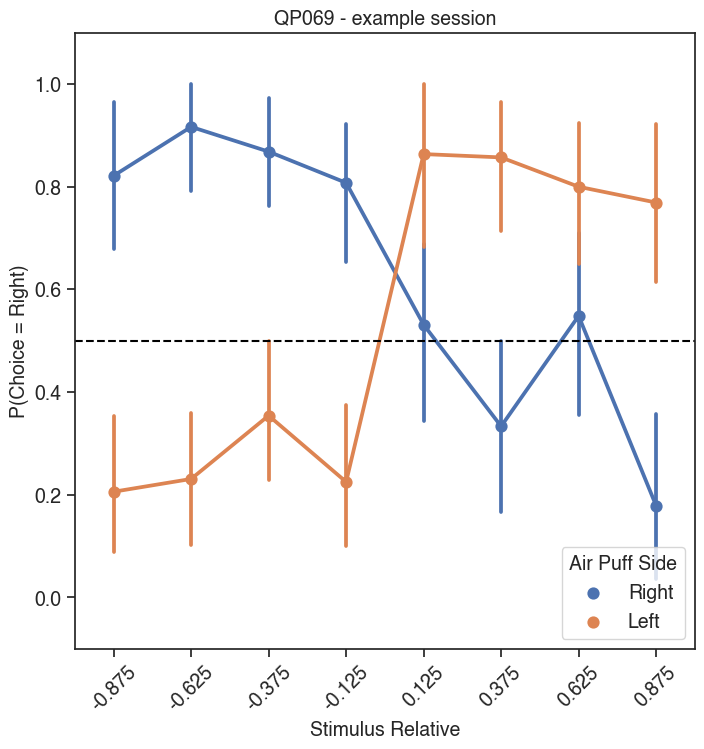

In [ ]:
valid_df = df[df.Abort_Trial == False].reset_index(drop=True)

color_dict = {'Pro': '#2F9A76', 'Anti': '#c23f63', 'Left': '#FFA500', 'Right': '#0000FF'},

fig, ax = plt.subplots(figsize=(8, 8))

sns.pointplot(x='stim_relative_binned', y='choice', hue='Air_Puff_Side', data=valid_df, ci=95)

# set y limit
ax.set_ylim(-0.1, 1.1)
# add horizontal line at y = 0.5
ax.axhline(0.5, ls='--', color='black')
# rotate x tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Stimulus Relative")
ax.set_ylabel("P(Choice = Right)")
ax.legend(loc='lower right', title='Air Puff Side')
ax.set_title(p_id + ' - example session')
# save as ped in figs_path
fig.savefig(figs_path + p_id + '_example_psychometric.pdf', bbox_inches='tight', dpi=300)

plt.show()

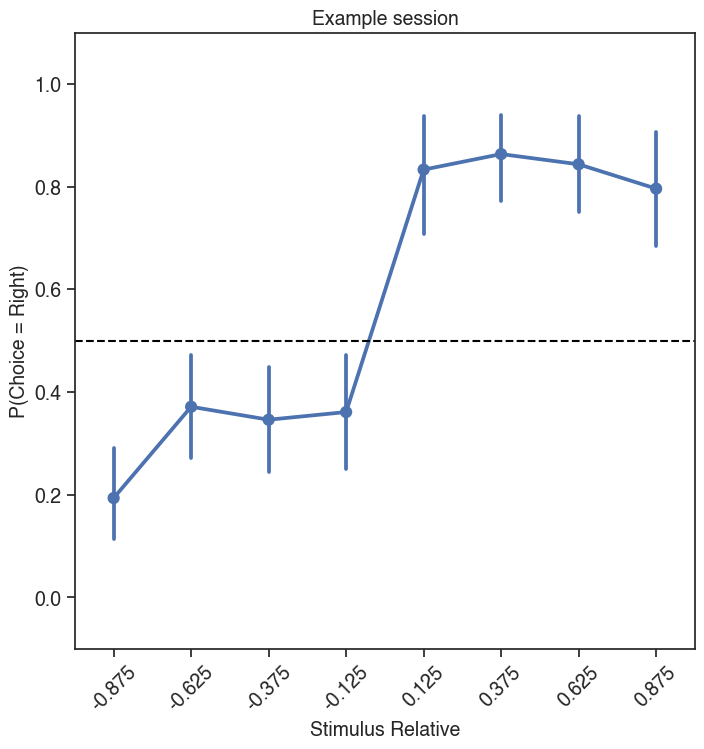

In [ ]:
# Create two separate DataFrames based on 'Air_Puff_Side'

# df = valid_df

left_df = df[df['Air_Puff_Side'] == 'Left'].reset_index(drop=True)
# left_df = left_df.replace({'stim_relative_binned': {-0.875: 0, -0.625: 0.25, -0.375: 0.5, -0.125: 0.75, 
#                                                     0.125: 1, 0.375: 1.25, 0.625: 1.5, 0.875: 1.75}})
right_df = df[df['Air_Puff_Side'] == 'Right'].reset_index(drop=True)

# Reverse the x-axis for 'Right' data
# right_df['stim_relative_binned'] = right_df['stim_relative_binned'].max() - right_df['stim_relative_binned']
right_df['stim_relative_binned'] = right_df['stim_relative_binned'].apply(lambda x: x * -1)

# concatenate two dataframes
concat_df = pd.concat([left_df, right_df])

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 8))

# Plot both DataFrames on the same axes
sns.pointplot(x='stim_relative_binned', y='choice', data=concat_df, ci=95)
# sns.pointplot(x='stim_relative_binned', y='choice', data=right_df, ci=95, label='Air_Puff_Side = Right', color='r')

# set y limit
ax.set_ylim(-0.1, 1.1)
# add horizontal line at y = 0.5
ax.axhline(0.5, ls='--', color='black')
# rotate x tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Stimulus Relative")
ax.set_ylabel("P(Choice = Right)")
# ax.legend(loc='lower right', title='Air Puff Side')
ax.set_title('Example session')

plt.show()

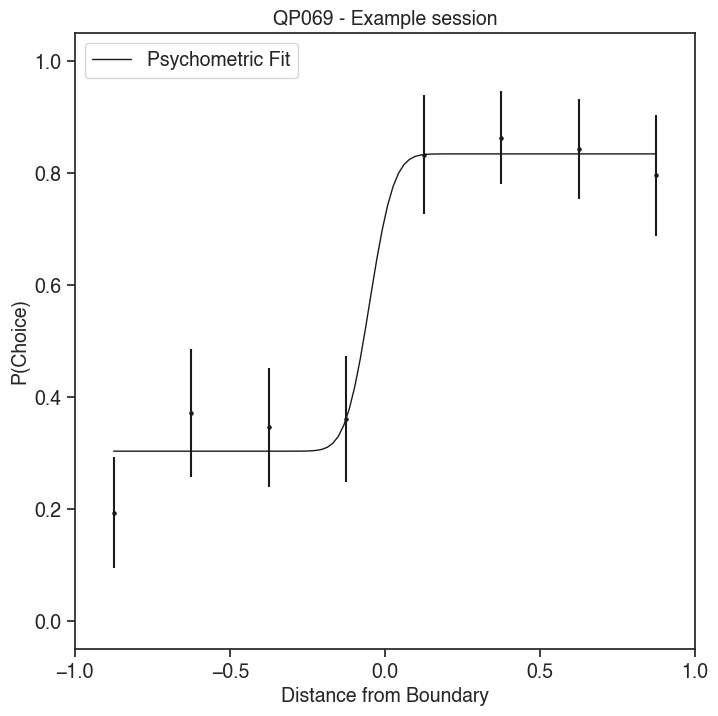

In [ ]:
df = valid_df
left_df = df[df['Air_Puff_Side'] == 'Left'].reset_index(drop=True)
right_df = df[df['Air_Puff_Side'] == 'Right'].reset_index(drop=True)

right_df['stim_relative_binned'] = right_df['stim_relative_binned'].apply(lambda x: x * -1)

concat_df = pd.concat([left_df, right_df])

popt = ut.psycho_fit(df = concat_df)[0]
fig, ax = plt.subplots(figsize=(8, 8))

ut.psycho_plot(df = concat_df, popt= popt, label= 'Psychometric Fit', color = 'k', ax = ax)
# y label
ax.set_ylabel("P(Choice)")
ax.legend(loc='upper left')  
ax.set_title(p_id + ' - Example session')
# save as pdf in figs_path
fig.savefig(figs_path + p_id + '_example_psychometric_fit.pdf', bbox_inches='tight', dpi=300)

In [ ]:
df[df.Air_Puff_Contingency == 'Pro']

,Animal_ID,Protocol,Stage,Trial_Number,Correct_Count,Sound_Contingency,Stim_Relative,Correct,Abort_Trial,Reward_Side,...,Opto_On,Mask,Fiber,Perc_Opto_Trials,Opto_Onset_1,Opto_Offset_1,Trial_End_Time,Air_Puff_Side,choice,stim_relative_binned
0,QP069,PRO_ANTI,Full_Task_Cont,1,1,Low_Left_High_Right,-0.584831,True,False,Right,...,False,False,False,NaN,NaN,NaN,33159.757043,Right,1,-0.625
2,QP069,PRO_ANTI,Full_Task_Cont,3,2,Low_Left_High_Right,-0.490492,False,False,Right,...,False,False,False,NaN,NaN,NaN,33170.356186,Left,1,-0.375
7,QP069,PRO_ANTI,Full_Task_Cont,8,4,Low_Left_High_Right,-0.325401,True,False,Right,...,False,False,False,NaN,NaN,NaN,33199.924109,Right,1,-0.375
8,QP069,PRO_ANTI,Full_Task_Cont,9,4,Low_Left_High_Right,-0.929944,False,False,Right,...,False,False,False,NaN,NaN,NaN,33206.612941,Left,1,-0.875
9,QP069,PRO_ANTI,Full_Task_Cont,10,4,Low_Left_High_Right,-0.123323,False,False,Right,...,False,False,False,NaN,NaN,NaN,33213.304934,Left,1,-0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,QP069,PRO_ANTI,Full_Task_Cont,581,381,Low_Left_High_Right,-0.230723,False,False,Right,...,False,False,False,NaN,NaN,NaN,36039.282394,Right,0,-0.125
507,QP069,PRO_ANTI,Full_Task_Cont,586,382,Low_Left_High_Right,-0.934201,True,False,Left,...,False,False,False,NaN,NaN,NaN,36069.884019,Left,0,-0.875
508,QP069,PRO_ANTI,Full_Task_Cont,587,382,Low_Left_High_Right,-0.926482,False,False,Left,...,False,False,False,NaN,NaN,NaN,36077.358413,Right,0,-0.875
510,QP069,PRO_ANTI,Full_Task_Cont,608,383,Low_Left_High_Right,-0.309385,False,False,Right,...,False,False,False,NaN,NaN,NaN,36214.762931,Left,1,-0.375


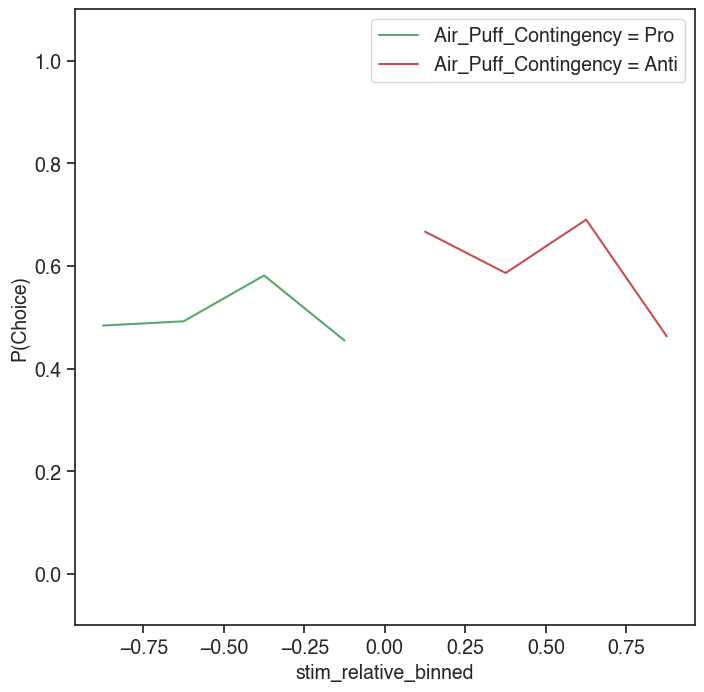

In [ ]:

valid_df = df[df.Abort_Trial == False].reset_index(drop=True)
pro_df = valid_df[valid_df.Air_Puff_Contingency == 'Pro'].reset_index(drop=True)
anti_df = valid_df[valid_df.Air_Puff_Contingency == 'Anti'].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 8))

sns.lineplot(x='stim_relative_binned', y='choice', data=pro_df, ci=None, label='Air_Puff_Contingency = Pro', color='g')
sns.lineplot(x='stim_relative_binned', y='choice', data=anti_df, ci=None, label='Air_Puff_Contingency = Anti', color='r')

# y lim and label
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel("P(Choice)")

plt.show()


In [ ]:
pro_df

,Animal_ID,Protocol,Stage,Trial_Number,Correct_Count,Sound_Contingency,Stim_Relative,Correct,Abort_Trial,Reward_Side,...,Opto_On,Mask,Fiber,Perc_Opto_Trials,Opto_Onset_1,Opto_Offset_1,Trial_End_Time,Air_Puff_Side,choice,stim_relative_binned
0,QP069,PRO_ANTI,Full_Task_Cont,1,1,Low_Left_High_Right,-0.584831,True,False,Right,...,False,False,False,NaN,NaN,NaN,33159.757043,Right,1,-0.625
1,QP069,PRO_ANTI,Full_Task_Cont,3,2,Low_Left_High_Right,-0.490492,False,False,Right,...,False,False,False,NaN,NaN,NaN,33170.356186,Left,1,-0.375
2,QP069,PRO_ANTI,Full_Task_Cont,8,4,Low_Left_High_Right,-0.325401,True,False,Right,...,False,False,False,NaN,NaN,NaN,33199.924109,Right,1,-0.375
3,QP069,PRO_ANTI,Full_Task_Cont,9,4,Low_Left_High_Right,-0.929944,False,False,Right,...,False,False,False,NaN,NaN,NaN,33206.612941,Left,1,-0.875
4,QP069,PRO_ANTI,Full_Task_Cont,10,4,Low_Left_High_Right,-0.123323,False,False,Right,...,False,False,False,NaN,NaN,NaN,33213.304934,Left,1,-0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,QP069,PRO_ANTI,Full_Task_Cont,581,381,Low_Left_High_Right,-0.230723,False,False,Right,...,False,False,False,NaN,NaN,NaN,36039.282394,Right,0,-0.125
273,QP069,PRO_ANTI,Full_Task_Cont,586,382,Low_Left_High_Right,-0.934201,True,False,Left,...,False,False,False,NaN,NaN,NaN,36069.884019,Left,0,-0.875
274,QP069,PRO_ANTI,Full_Task_Cont,587,382,Low_Left_High_Right,-0.926482,False,False,Left,...,False,False,False,NaN,NaN,NaN,36077.358413,Right,0,-0.875
275,QP069,PRO_ANTI,Full_Task_Cont,608,383,Low_Left_High_Right,-0.309385,False,False,Right,...,False,False,False,NaN,NaN,NaN,36214.762931,Left,1,-0.375


In [ ]:
anti_df

,Animal_ID,Protocol,Stage,Trial_Number,Correct_Count,Sound_Contingency,Stim_Relative,Correct,Abort_Trial,Reward_Side,...,Opto_On,Mask,Fiber,Perc_Opto_Trials,Opto_Onset_1,Opto_Offset_1,Trial_End_Time,Air_Puff_Side,choice,stim_relative_binned
0,QP069,PRO_ANTI,Full_Task_Cont,2,2,Low_Left_High_Right,0.960428,True,False,Right,...,False,False,False,NaN,NaN,NaN,33163.486221,Left,1,0.875
1,QP069,PRO_ANTI,Full_Task_Cont,4,2,Low_Left_High_Right,0.768471,False,False,Right,...,False,False,False,NaN,NaN,NaN,33177.046349,Right,1,0.875
2,QP069,PRO_ANTI,Full_Task_Cont,5,2,Low_Left_High_Right,0.523145,False,False,Right,...,False,False,False,NaN,NaN,NaN,33185.674138,Left,0,0.625
3,QP069,PRO_ANTI,Full_Task_Cont,6,2,Low_Left_High_Right,0.622072,False,False,Right,...,False,False,False,NaN,NaN,NaN,33192.382541,Left,0,0.625
4,QP069,PRO_ANTI,Full_Task_Cont,7,3,Low_Left_High_Right,0.025883,True,False,Right,...,False,False,False,NaN,NaN,NaN,33196.157376,Left,1,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,QP069,PRO_ANTI,Full_Task_Cont,544,377,Low_Left_High_Right,0.195530,True,False,Right,...,False,False,False,NaN,NaN,NaN,35797.697702,Left,1,0.125
233,QP069,PRO_ANTI,Full_Task_Cont,583,381,Low_Left_High_Right,0.582979,False,False,Right,...,False,False,False,NaN,NaN,NaN,36052.630592,Left,0,0.625
234,QP069,PRO_ANTI,Full_Task_Cont,589,383,Low_Left_High_Right,0.196814,True,False,Right,...,False,False,False,NaN,NaN,NaN,36087.737549,Left,1,0.125
235,QP069,PRO_ANTI,Full_Task_Cont,629,384,Low_Left_High_Right,0.643479,False,False,Left,...,False,False,False,NaN,NaN,NaN,36354.203200,Right,1,0.625


In [ ]:
# i have 2 osychometirc curves, one for left and one for right
# the psychometric curve is a sigmoid for the Left trials, and a reverse sigmoid for the Right trials
# I want to combine everything into one psychometric curve, meaning that the the x-axis will be distance from boundary (-1 to 1) for the left
# and (1 to -1) for the right
# similarly, the y-axis will be the probability of choosing right for the left, and the probability of choosing left for the right
# How do I rename my axes intelligently so that I can plot them on the same graph?

In [ ]:
x_range = np.linspace(0, 1, 50) * (-1)
stimuli = air_puff_R_below_0.Stim_Relative.values
choices = air_puff_R_below_0.choice.values
sigma = 0.1

In [ ]:
d = np.abs(x_range[:, np.newaxis] - stimuli[np.newaxis, :])

In [ ]:
inter_var = ((d/sigma)**2)*(-1/2)

In [ ]:
type(d)

numpy.ndarray

In [ ]:
np.shape(d)

(50, 41557)

In [ ]:
first_element_exp = np.exp(inter_var[0])


TypeError: loop of ufunc does not support argument 0 of type float which has no callable exp method

In [ ]:
np.exp(-(1/2)*(d/sigma)**2)

In [ ]:
import numpy as np

# Replace 'd' with your actual variable name if it's different
# The following code checks the type, dtype, if it's scalar, and its shape
info = {
    "type": type(d),
    "dtype": str(d.dtype) if isinstance(d, np.ndarray) else "Not a ndarray",
    "is_scalar": np.isscalar(d),
    "shape": d.shape if isinstance(d, np.ndarray) else "Not a ndarray",
    "first_element": d[0] if isinstance(d, np.ndarray) else "Not a ndarray",
    "code_execution": "Not executed"
}

# Attempt to execute the problematic code
try:
    result = np.exp(-(1/2)*(d/0.1)**2)
    info["code_execution"] = "Executed successfully"
    info["result_first_element"] = result[0] if isinstance(result, np.ndarray) else result
except Exception as e:
    info["code_execution"] = f"Execution failed: {e}"

print(info)


{'type': <class 'numpy.ndarray'>, 'dtype': 'object', 'is_scalar': False, 'shape': (50, 41557), 'first_element': array([0.7123117, 0.4366424, 0.4657312, ..., 0.5973827, 0.6313815,
       0.9952569], dtype=object), 'code_execution': 'Execution failed: loop of ufunc does not support argument 0 of type float which has no callable exp method'}


In [ ]:
# Attempt to convert 'd' to a numeric type (e.g., float64)
d_numeric = d.astype(np.float64)

# Now try to perform the operation with the numeric array
result = np.exp(-(1/2)*(d_numeric/0.1)**2)


In [ ]:
result

array([[9.59865724e-12, 7.24343971e-05, 1.94964622e-05, ...,
        1.78135842e-08, 2.20590071e-09, 3.09583356e-22],
       [4.02252903e-11, 1.72943260e-04, 4.93965313e-05, ...,
        5.90441244e-08, 7.83691237e-09, 2.31123954e-21],
       [1.61696203e-10, 3.96072207e-04, 1.20046369e-04, ...,
        1.87721491e-07, 2.67064372e-08, 1.65510003e-20],
       ...,
       [4.74875093e-02, 1.17708546e-06, 5.15900318e-06, ...,
        1.43728808e-03, 4.64152062e-03, 9.37007602e-01],
       [2.81014648e-02, 3.96851158e-07, 1.84572630e-06, ...,
        6.72713375e-04, 2.32852111e-03, 9.87805256e-01],
       [1.59510934e-02, 1.28339175e-07, 6.33403908e-07, ...,
        3.02014807e-04, 1.12050038e-03, 9.98875783e-01]])